In [1]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler, StableDiffusionImg2ImgPipeline, image_processor
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import numpy as np
from PIL import Image
import torch.nn.functional as F
from diffusers.models.attention import Attention
from typing import Optional
import requests
from io import BytesIO
# from tqdm.auto import tqdm
from tqdm import tqdm

/Users/andrewbelyaev/UIUC/SemanticAttack/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
class AttnProcessor:
    """
    Default processor for performing attention-related computations.
    """
    def __init__(self):
        # Initialize an empty list to store attention maps for each call
        self.attention_maps = []
        # self.hidden_states = []
        # self.encoder_hidden_states = []
        # self.attention_mask = []

    def __call__(
        self,
        attn: Attention,
        hidden_states: torch.Tensor,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        temb: Optional[torch.Tensor] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)

        res = int(np.sqrt(attention_probs.shape[1]))
        num_tokens = attention_probs.shape[-1]
        self.attention_maps.append(attention_probs.view(-1, res, res, num_tokens))
        # self.hidden_states.append(hidden_states)
        # self.encoder_hidden_states.append(encoder_hidden_states)
        # self.attention_mask.append(attention_mask)

        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

In [76]:
class SemanticAttack():
    def __init__(self,
                 image,
                 editing_prompt,
                 token, device,
                 attention_processor_class=AttnProcessor,
                 num_inference_steps_mask=50,
                 mask_threshold=0.5,
                 perturbation_budget=0.06,
                 attacking_step_size=0.01,
                 number_of_attacking_steps=100,
                 num_diffusion_steps=10) -> None:

        self.token = token
        self.editing_prompt = editing_prompt
        self.attention_processor_class = attention_processor_class
        # self.attention_maps = {}

        # constants (move it to the sem att function
        self.mask_threshold = mask_threshold
        self.perturbation_budget = perturbation_budget
        self.attacking_step_size = attacking_step_size
        self.number_of_attacking_steps = number_of_attacking_steps
        self.num_diffusion_steps = num_diffusion_steps

        self.strength = 0.5
        self.guidance_scale = 6
        self.num_inference_steps_mask = num_inference_steps_mask

        # Initializing block for the Stable Diffusion Model
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
        self.tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder",
                                                          use_safetensors=True)
        self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet",
                                                         use_safetensors=True)
        self.scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

        # Let's also save pipeline to use it's functions
        self.pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                                                       safety_checker=None,
                                                                       requires_safety_checker=False)

        # choosing device
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
        print("Using:", self.device)

        self.generator = torch.Generator(device=self.device)
        torch.manual_seed(0)

        self.vae.to(self.device)
        self.text_encoder.to(self.device)
        self.unet.to(self.device)

        self.image = image
        self.preprocessed_image = self.pipeline.image_processor.preprocess(image).to(
            self.device)  # maybe VAE image processor?

        self.transformer_block_name_to_attention_processor_map = {}
        self.register_custom_attention_processors()

        self.mask = None
        self.latent_shape = None
        self.text_embeddings = None
        self.init_latent = None

        self.loss = []

    def upsample_attention(self, attention_map, target_res):  # works
        '''
        Upsamples attention map to a specific shape
        attention_map: torch.Tensor of size: [batch_size * n_heads, res, res, n_tokens]
        shape: tuple,
        return: torch.Tensor of size: [batch_size * n_heads, target_res, target_res, n_tokens]
        '''
        batch_size_n_heads, _, res, n_tokens = attention_map.shape
        # [batch_size * n_heads, target_res, target_res, n_tokens] -> [batch_size * n_heads * n_tokens, 1, target_res, target_res]
        attention_map = attention_map.permute(0, 3, 1, 2).reshape(-1, 1, res, res)
        attention_map = F.interpolate(attention_map, size=(target_res, target_res), mode='bicubic', align_corners=False)
        # [batch_size * n_heads * n_tokens, 1, target_res, target_res] -> [batch_size * n_heads, target_res, target_res, n_tokens]
        attention_map = attention_map.reshape(batch_size_n_heads, n_tokens, target_res, target_res).permute(0, 2, 3, 1)
        return attention_map

    def average_attention_maps(self):  # works
        '''
        Upsamples the attention maps and averages them across all layers.
        num_steps: int, the number of timesteps to average over.
        '''
        resolution_to_upsample_to = 64
        to_average = []
        for key, value in self.transformer_block_name_to_attention_processor_map.items():
            # attention_map = value.attention_maps[-num_steps:].copy()
            # attention_map = sum(attention_map) / len(attention_map)
            avg_attention_map = value.sum_attention_maps / value.counter
            res = avg_attention_map.shape[1]
            if res == resolution_to_upsample_to:
                to_average.append(avg_attention_map)
            else:
                to_average.append(self.upsample_attention(avg_attention_map, resolution_to_upsample_to))
        to_average = torch.cat(to_average, dim=0)
        averaged = to_average.sum(dim=0) / to_average.shape[0]
        # del to_average
        # del attention_map
        return averaged

    def denoise(self):
        '''
        Generates mask using sampling from the noisy state obtained with forward pass.
        '''
        # check_memory()

        # text embeddings
        text_embeddings = self.get_text_embeddings(prompt=self.token)
        # print(get_tensor_size(text_embeddings))

        with torch.no_grad():
            # timesteps
            self.scheduler.set_timesteps(self.num_inference_steps_mask, device=self.device)

            init_timestep = min(int(self.num_inference_steps_mask * self.strength), self.num_inference_steps_mask)
            t_start = max(self.num_inference_steps_mask - init_timestep, 0)

            timesteps = self.scheduler.timesteps[t_start:]
            num_inference_steps = self.num_inference_steps_mask - t_start

            # latents
            # init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            init_latent = self.get_init_latent()

            # print(get_tensor_size(init_latent))
            self.latent_shape = init_latent.shape
            init_latent = self.vae.config.scaling_factor * init_latent
            noise = torch.randn(init_latent.shape, generator=self.generator, device=self.device)
            latent_timestep = timesteps[:1]
            latent = self.scheduler.add_noise(init_latent, noise, latent_timestep)

            for t in tqdm(timesteps, total=len(timesteps)):
                latent_model_input = torch.cat([latent] * 2)  # cfg
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                # print(get_tensor_size(latent_model_input))

                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings,
                    # timestep_cond=None,
                    # cross_attention_kwargs=self.cross_attention_kwargs,
                    # added_cond_kwargs=added_cond_kwargs,
                    # return_dict=False,
                )[0]

                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                latent = self.scheduler.step(noise_pred, t, latent, return_dict=False)[0]
        return

    def generate_mask_using_forward_noise(self):
        self.clean_attention_processors()
        self.denoise()
        attention_map = self.average_attention_maps()
        token_attention_map = attention_map[:, :, 1]
        masked_token_attention_map = token_attention_map * (token_attention_map > token_attention_map.max() * self.mask_threshold)
        mask = masked_token_attention_map.unsqueeze(0).unsqueeze(0).repeat(1, self.latent_shape[1], 1, 1)
        self.mask = mask
        self.clean_attention_processors()

    def clean_attention_processors(self):
        for key, value in self.transformer_block_name_to_attention_processor_map.items():
            value.sum_attention_maps = None
            value.counter = 0
        # gc.collect()

    def get_text_embeddings(self, prompt):
        '''
        Gets text embedding with classifier-free guidance
        :return: text embeddings
        '''

        if self.text_embeddings is None:

            text_input = self.tokenizer(
                prompt,
                padding="max_length",
                # max_length=self.tokenizer.model_max_length,
                max_length=10,
                truncation=True,
                return_tensors="pt",
            )
            with torch.no_grad():
                # embeddings
                text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

                # classifier free guidance
                max_length = text_input.input_ids.shape[-1]
                uncond_input = self.tokenizer("", padding="max_length", max_length=max_length, return_tensors="pt")
                uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

                text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

                self.text_embeddings = text_embeddings

        else:
            text_embeddings = self.text_embeddings

        return text_embeddings

    def get_init_latent(self):
        if self.init_latent is None:
            init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            self.init_latent = init_latent
        else:
            init_latent = self.init_latent
        return init_latent

    def timestep_universal_gradient_updating(self):
        '''
        Performs universal gradient updating.
        '''

        text_embeddings = self.get_text_embeddings(prompt=self.token)
        # text_embeddings = self.text_embeddings

        self.scheduler.set_timesteps(self.num_diffusion_steps, device=self.device)

        diffusion_timesteps = self.scheduler.timesteps

        with torch.no_grad():
            # init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            init_latent = self.get_init_latent().to(self.device)
            init_latent = (self.vae.config.scaling_factor * init_latent).to(self.device)
            delta = torch.zeros(init_latent.shape).to(self.device)


        for attacking_step in tqdm(range(self.number_of_attacking_steps), total=self.number_of_attacking_steps,
                                   desc="Attacking steps"):
            accumulated_grad = torch.zeros(init_latent.shape).to(self.device).requires_grad_(False)  # Accumulate gradient across timesteps
            for t in tqdm(diffusion_timesteps, total=len(diffusion_timesteps),
                          desc=f"Attacking step {attacking_step + 1}"):
                with torch.autograd.profiler.profile() as prof:
                    init_latent_adv = init_latent.clone().detach().requires_grad_(True)
                    noise = torch.randn(init_latent_adv.shape, generator=self.generator, device=self.device)
                    noised_adv_latent = self.scheduler.add_noise(init_latent_adv, noise, t)

                    latent_model_input = torch.cat([noised_adv_latent] * 2)  # cfg
                    latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                    masked_latent_model_input = self.mask * latent_model_input
                    noise_pred = self.unet(
                        masked_latent_model_input,
                        t,
                        encoder_hidden_states=text_embeddings,
                        # timestep_cond=None,
                        # cross_attention_kwargs=self.cross_attention_kwargs,
                        # added_cond_kwargs=added_cond_kwargs,
                        # return_dict=False,
                    )[0]
                    # del noise_pred

                    # calculating loss
                    attention_map = self.average_attention_maps()[:, :, 1]
                    if init_latent_adv.grad is not None:
                        init_latent_adv.grad.zero_()
                    loss = torch.norm(attention_map, p=1)
                    self.loss.append(loss.item())
                    # loss = torch.norm(latent_model_input)
                    loss.backward()

                    ##
                    # self.print_graph(attention_map)
                    ##
                    with torch.no_grad():
                        accumulated_grad += init_latent_adv.grad
                self.clean_attention_processors()

                # print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))
                # for event in prof.function_events:
                #     print(event)
            grad = accumulated_grad / len(diffusion_timesteps)
            delta = delta + self.attacking_step_size * torch.sign(grad)
            delta.clamp_(-self.perturbation_budget, self.perturbation_budget)
            with torch.no_grad():
                init_latent = (init_latent - delta).detach()  # Reset for next step

        return init_latent

    def register_custom_attention_processors(self):
        '''
        Registers a custom attention processor for each BasicTransformerBlock in the U-Net to extract attention maps after softmax.
        processor: class
        '''
        for name, module in self.unet.named_modules():
            if module.__class__.__name__ == 'BasicTransformerBlock':
                module.attn2.processor = self.attention_processor_class()
                self.transformer_block_name_to_attention_processor_map[name] = module.attn2.processor

    def show_attention_maps(self, directions, token, resolution):
        '''
        Shows averaged cross attention across timesteps, batch * n_heads, and layers
        with the same resolution attention maps for a given resolution and direction.
        direction: list, for example ["down", "up", "mid"]
        token: int, for example 1
        resolution: int for example 16
        '''
        filtered_attention_sums = []
        for key, value in self.transformer_block_name_to_attention_processor.items():
            dir = key.split("_")[0]
            res = value.sum_attention_maps.shape[1]
            if dir in directions and res == resolution:
                filtered_attention_sums.append(value.sum_attention_maps)
        filtered_attention_sums = torch.cat(filtered_attention_sums, dim=0)
        filtered_attention_sums = filtered_attention_sums.sum(dim=0) / filtered_attention_sums.shape[0]
        filtered_attention_sums = filtered_attention_sums[:, :, token]
        filtered_attention_sums = 255 * filtered_attention_sums / filtered_attention_sums.max()
        filtered_attention_sums = filtered_attention_sums.unsqueeze(-1).expand(*filtered_attention_sums.shape, 3)
        filtered_attention_sums = filtered_attention_sums.numpy().astype(np.uint8)
        return Image.fromarray(filtered_attention_sums).resize((256, 256))


In [2]:
def load_image(url, size=None):
    response = requests.get(url,timeout=1)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

In [3]:
# input_image = load_image('https://images.pexels.com/photos/415829/pexels-photo-415829.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2', size=(640//2, 564//2))
input_image = load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
# from google.colab import drive
# drive.mount('/content/drive')

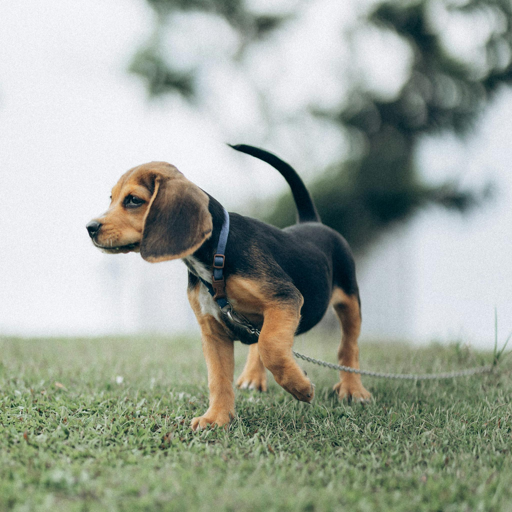

In [4]:
input_image

In [40]:
input_image.

TypeError: 'Image' object is not subscriptable

In [10]:
torch.from_numpy(np.array(input_image))

tensor([[[235, 236, 240],
         [239, 240, 244],
         [243, 244, 248],
         ...,
         [115, 132, 120],
         [128, 141, 131],
         [137, 149, 139]],

        [[240, 241, 245],
         [239, 240, 244],
         [243, 244, 248],
         ...,
         [112, 129, 117],
         [127, 140, 130],
         [135, 147, 137]],

        [[244, 245, 249],
         [241, 242, 246],
         [237, 238, 242],
         ...,
         [105, 122, 111],
         [121, 134, 124],
         [131, 143, 133]],

        ...,

        [[120, 132,  96],
         [123, 135,  99],
         [121, 133,  97],
         ...,
         [147, 157, 132],
         [149, 159, 134],
         [145, 155, 130]],

        [[120, 129,  94],
         [128, 137, 102],
         [126, 134, 100],
         ...,
         [149, 159, 134],
         [149, 159, 134],
         [143, 153, 128]],

        [[127, 134, 100],
         [129, 136, 102],
         [130, 137, 103],
         ...,
         [144, 154, 129],
        

In [77]:
model = SemanticAttack(image=input_image,
              editing_prompt="cat on the grass",
              token='dog',
              device="cpu",
              attention_processor_class=AttnProcessor,
              #  pipeline_class=StableDiffusionImg2ImgPipeline,
              #  scheduler_class=DDIMScheduler,
              num_inference_steps_mask=50)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Using: cpu


In [41]:
model.preprocessed_image

tensor([[[[ 0.8431,  0.8745,  0.9059,  ..., -0.0980,  0.0039,  0.0745],
          [ 0.8824,  0.8745,  0.9059,  ..., -0.1216, -0.0039,  0.0588],
          [ 0.9137,  0.8902,  0.8588,  ..., -0.1765, -0.0510,  0.0275],
          ...,
          [-0.0588, -0.0353, -0.0510,  ...,  0.1529,  0.1686,  0.1373],
          [-0.0588,  0.0039, -0.0118,  ...,  0.1686,  0.1686,  0.1216],
          [-0.0039,  0.0118,  0.0196,  ...,  0.1294,  0.1686,  0.1451]],

         [[ 0.8510,  0.8824,  0.9137,  ...,  0.0353,  0.1059,  0.1686],
          [ 0.8902,  0.8824,  0.9137,  ...,  0.0118,  0.0980,  0.1529],
          [ 0.9216,  0.8980,  0.8667,  ..., -0.0431,  0.0510,  0.1216],
          ...,
          [ 0.0353,  0.0588,  0.0431,  ...,  0.2314,  0.2471,  0.2157],
          [ 0.0118,  0.0745,  0.0510,  ...,  0.2471,  0.2471,  0.2000],
          [ 0.0510,  0.0667,  0.0745,  ...,  0.2078,  0.2471,  0.2235]],

         [[ 0.8824,  0.9137,  0.9451,  ..., -0.0588,  0.0275,  0.0902],
          [ 0.9216,  0.9137,  

In [53]:
for param in model.vae.parameters():
    # param.requires_grad = True
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [78]:
image_adv = model.preprocessed_image.clone().detach().requires_grad_(True)
# model.vae.train()
latent = model.vae.encode(image_adv).latent_dist.sample(model.generator)

In [79]:
loss = latent.mean()  # Example loss
loss.backward()  # This should not raise any errors
print(loss)

tensor(1.1737, grad_fn=<MeanBackward0>)


In [80]:
image_adv.grad

tensor([[[[-4.0758e-04, -1.2727e-04,  5.7062e-05,  ..., -1.3879e-05,
           -1.0123e-05, -4.6047e-07],
          [-1.7829e-04,  3.8102e-04,  3.9814e-04,  ...,  6.5337e-06,
           -4.0270e-06, -4.7245e-06],
          [-1.0417e-04,  7.1740e-04,  6.2096e-04,  ..., -6.7999e-06,
            1.7495e-05,  9.2273e-06],
          ...,
          [-1.7986e-06,  4.6161e-05,  2.7348e-05,  ...,  1.2248e-05,
           -2.0127e-05,  1.7862e-05],
          [-1.0560e-05,  6.3606e-05,  3.3376e-05,  ...,  1.0944e-04,
            6.8569e-06,  1.3178e-06],
          [-1.4212e-05,  1.8544e-05,  3.1712e-05,  ...,  6.4114e-06,
           -2.0647e-05,  3.8740e-06]],

         [[-1.2451e-04,  6.1693e-05,  1.3422e-04,  ..., -2.3411e-05,
           -1.1760e-05,  6.2840e-06],
          [-1.7841e-04,  1.2615e-04,  1.4411e-04,  ...,  1.4213e-06,
           -1.4932e-06,  5.5853e-06],
          [-1.4662e-04,  2.1962e-04,  3.2836e-04,  ..., -1.6088e-05,
            3.5160e-05,  3.5602e-05],
          ...,
     

In [68]:
latent.grad

/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_82762/3022972074.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  latent.grad


In [29]:
init_latent_adv = latent.clone().detach()

AttributeError: 'AutoencoderKLOutput' object has no attribute 'clone'

In [8]:
model.generate_mask_using_forward_noise()

100%|██████████| 25/25 [01:31<00:00,  3.66s/it]


In [10]:
immunized_latent = model.timestep_universal_gradient_updating()

Attacking steps:   0%|          | 0/10 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [39]:
decoded_latent = model.vae.decode(immunized_latent / model.vae.config.scaling_factor, return_dict=False, generator=model.generator)[0]

In [40]:
immunized_image = model.pipeline.image_processor.postprocess(decoded_latent.detach(), output_type='pil', do_denormalize=[True])

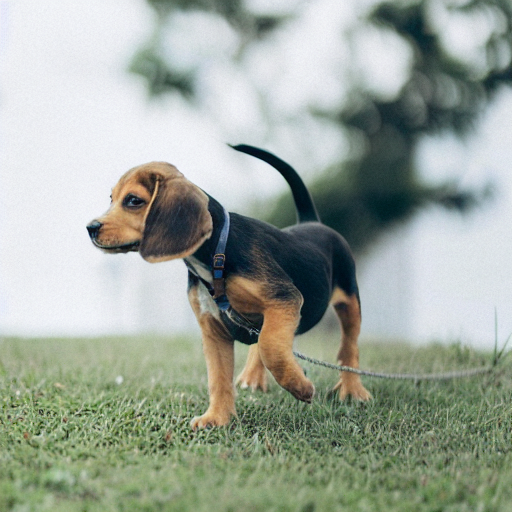

In [41]:
immunized_image[0]

In [42]:
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", safety_checker = None, requires_safety_checker = False)
# pipeline.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [43]:
pipeline_output = pipeline(prompt='cat on the grass', image=immunized_image[0],  strength=0.7, guidance_scale=6, num_inference_steps=50)

  0%|          | 0/30 [00:00<?, ?it/s]

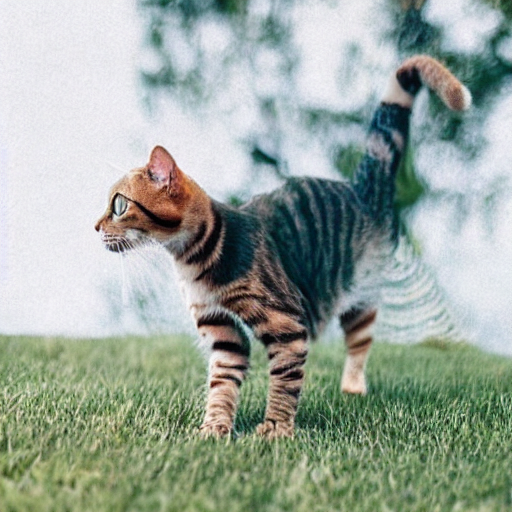

In [44]:
pipeline_output.images[0]

In [34]:
not_immunized_pipeline_output = pipeline(prompt='cat on the grass', image=input_image,  strength=0.7, guidance_scale=6, num_inference_steps=50)

  0%|          | 0/35 [00:00<?, ?it/s]

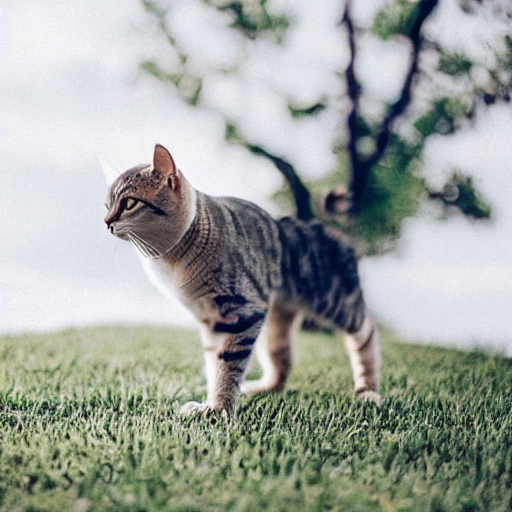

In [35]:
not_immunized_pipeline_output.images[0]

In [ ]:
###

In [31]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x * 2 + 1
z = y.mean()

print("z grad_fn:", z.grad_fn.next_functions)  # Shows the final operation
print("y grad_fn:", y.grad_fn.next_functions)  # Shows the operation creating `y`


z grad_fn: ((<AddBackward0 object at 0x16a838f70>, 0),)
y grad_fn: ((<MulBackward0 object at 0x119f1f640>, 0), (None, 0))


In [32]:
def print_graph(fn, indent=0):
    if fn is None:
        return
    print("  " * indent + str(fn))
    for next_fn, _ in fn.next_functions:
        print_graph(next_fn, indent + 1)

In [33]:
print_graph(z.grad_fn)


In [35]:
with torch.autograd.profiler.profile() as prof:
    x = torch.randn(100, 100, requires_grad=True)
    y = x ** 2
    z = y.mean()
    z.backward()

# Print a summary of the recorded operations, including tensors involved
print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::randn         5.63%      29.583us        37.73%     198.176us     198.176us             1  
                                            aten::empty         2.60%      13.668us         2.60%      13.668us      13.668us             1  
                                          aten::normal_        29.50%     154.925us        29.50%     154.925us     154.925us             1  
                                              aten::pow        14.73%      77.378us        16.38%      86.045us      43.022us             2  
      

In [37]:
from torchviz import make_dot
make_dot(z, params={"x": x, "y": y}).render("computation_graph", format="png")

'computation_graph.png'

In [12]:
decoded_latent = model.vae.decode(latent / model.vae.config.scaling_factor, return_dict=False, generator=model.generator)[0]

In [14]:
image = model.pipeline.image_processor.postprocess(decoded_latent.detach(), output_type='pil', do_denormalize=[True])

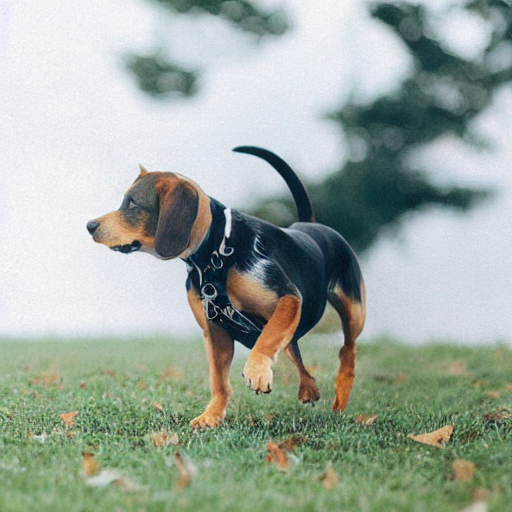

In [15]:
image[0]

In [9]:
attention_map = model.average_attention_maps(num_steps=50)

ZeroDivisionError: division by zero

In [35]:
attention_map.shape

torch.Size([64, 64, 10])

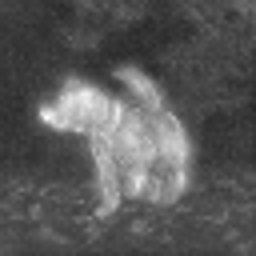

In [20]:
token = 1
token_attention_map = attention_map[:, :, token].clone()
attention_map_image = 255 * token_attention_map / token_attention_map.max()
attention_map_image = attention_map_image.unsqueeze(-1).expand(*attention_map_image.shape, 3)
attention_map_image = attention_map_image.numpy().astype(np.uint8)
# aggregated = np.array(Image.fromarray(aggregated).resize((256, 256)))
Image.fromarray(attention_map_image).resize((256, 256))

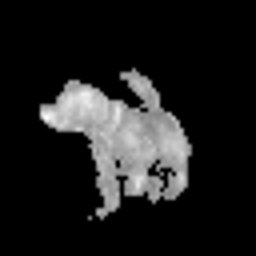

In [29]:
mask = attention_map_image * (attention_map_image > 130)
Image.fromarray(mask).resize((256, 256))

In [57]:
import gc
gc.collect()

0

In [58]:
token_attention_map.max(), token_attention_map.min() 

(tensor(0.0301), tensor(0.0047))

In [44]:
token_attention_map * (token_attention_map > token_attention_map.max() * 0.5)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [45]:
masked_token_attention_map = token_attention_map * (token_attention_map > token_attention_map.max() * 0.5)

In [47]:
masked_token_attention_map = masked_token_attention_map.unsqueeze(0).unsqueeze(0).repeat(1, 4, 1, 1) 

In [49]:
init_latent = model.vae.encode(model.preprocessed_image).latent_dist.sample(model.generator)

In [52]:
decoded_masked_latent = model.vae.decode(masked_token_attention_map * init_latent / model.vae.config.scaling_factor, return_dict=False, generator=model.generator)[0]

In [53]:
masked_image = model.pipeline.image_processor.postprocess(decoded_masked_latent.detach(), output_type='pil', do_denormalize=[True])

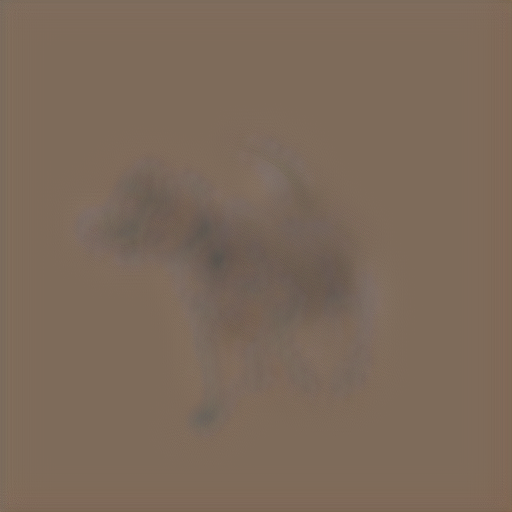

In [55]:
masked_image[0]

In [60]:
latent.shape

torch.Size([1, 4, 64, 64])

In [1]:
from memory_profiler import profile

@profile
def your_function():
    # Code you want to profile
    a = [i for i in range(100000)]  # Example line with memory impact
    b = [i * 2 for i in a]          # Another line
    del a 

In [ ]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler, StableDiffusionImg2ImgPipeline, image_processor
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import numpy as np
from PIL import Image
import torch.nn.functional as F
from diffusers.models.attention import Attention
from typing import Optional
import requests
from io import BytesIO
from tqdm.auto import tqdm
from memory_profiler import profile



class AttnProcessor:
    """
    Default processor for performing attention-related computations.
    """
    def __init__(self):
        # Initialize an empty list to store attention maps for each call
        self.attention_maps = []
        # self.hidden_states = []
        # self.encoder_hidden_states = []
        # self.attention_mask = []

    def __call__(
        self,
        attn: Attention,
        hidden_states: torch.Tensor,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        temb: Optional[torch.Tensor] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)

        res = int(np.sqrt(attention_probs.shape[1]))
        num_tokens = attention_probs.shape[-1]
        self.attention_maps.append(attention_probs.view(-1, res, res, num_tokens))
        # self.hidden_states.append(hidden_states)
        # self.encoder_hidden_states.append(encoder_hidden_states)
        # self.attention_mask.append(attention_mask)

        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

def load_image(url, size=None):
    response = requests.get(url,timeout=1)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

# def check_memory():
#     process = psutil.Process(os.getpid())
#     print(f"Memory used: {process.memory_info().rss / (1024 * 1024):.2f} MB")

def get_tensor_size(tensor: torch.Tensor) -> int:
    return tensor.element_size() * tensor.nelement() / (1024 * 1024)

class SemanticAttack():
    def __init__(self,
                 image,
                 editing_prompt,
                 token, device,
                 attention_processor_class=AttnProcessor,
                 num_inference_steps_mask=50,
                 mask_threshold=0.5,
                 perturbation_budget=0.06,
                 attacking_step_size=0.01,
                 number_of_attacking_steps=100,
                 num_diffusion_steps=10) -> None:

        self.token = token
        self.editing_prompt = editing_prompt
        self.attention_processor_class = attention_processor_class
        # self.attention_maps = {}

        # constants (move it to the sem att function
        self.mask_threshold = mask_threshold
        self.perturbation_budget = perturbation_budget
        self.attacking_step_size = attacking_step_size
        self.number_of_attacking_steps = number_of_attacking_steps
        self.num_diffusion_steps = num_diffusion_steps

        self.strength = 0.5
        self.guidance_scale = 6
        self.num_inference_steps_mask = num_inference_steps_mask

        # Initializing block for the Stable Diffusion Model
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
        self.tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder",
                                                          use_safetensors=True)
        self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet",
                                                         use_safetensors=True)
        self.scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

        # Let's also save pipeline to use it's functions
        self.pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                                                       safety_checker=None,
                                                                       requires_safety_checker=False)

        # choosing device
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
        print("Using:", self.device)

        self.generator = torch.Generator(device=self.device)
        torch.manual_seed(0)

        self.vae.to(self.device)
        self.text_encoder.to(self.device)
        self.unet.to(self.device)

        self.image = image
        self.preprocessed_image = self.pipeline.image_processor.preprocess(image).to(
            self.device)  # maybe VAE image processor?

        self.transformer_block_name_to_attention_processor_map = {}
        self.register_custom_attention_processors()

        self.mask = None
        self.latent_shape = None
        self.text_embeddings = None
        self.init_latent = None

    def upsample_attention(self, attention_map, target_res):  # works
        '''
        Upsamples attention map to a specific shape
        attention_map: torch.Tensor of size: [batch_size * n_heads, res, res, n_tokens]
        shape: tuple,
        return: torch.Tensor of size: [batch_size * n_heads, target_res, target_res, n_tokens]
        '''
        batch_size_n_heads, _, res, n_tokens = attention_map.shape
        # [batch_size * n_heads, target_res, target_res, n_tokens] -> [batch_size * n_heads * n_tokens, 1, target_res, target_res]
        attention_map = attention_map.permute(0, 3, 1, 2).reshape(-1, 1, res, res)
        attention_map = F.interpolate(attention_map, size=(target_res, target_res), mode='bicubic', align_corners=False)
        # [batch_size * n_heads * n_tokens, 1, target_res, target_res] -> [batch_size * n_heads, target_res, target_res, n_tokens]
        attention_map = attention_map.reshape(batch_size_n_heads, n_tokens, target_res, target_res).permute(0, 2, 3, 1)
        return attention_map

    def average_attention_maps(self, num_steps=1):  # works
        '''
        Upsamples the attention maps and averages them across all layers.
        num_steps: int, the number of timesteps to average over.
        '''
        resolution_to_upsample_to = 64
        to_average = []
        for key, value in self.transformer_block_name_to_attention_processor_map.items():
            attention_map = value.attention_maps[-num_steps:].copy()
            attention_map = sum(attention_map) / len(attention_map)
            res = attention_map.shape[1]
            if res == resolution_to_upsample_to:
                to_average.append(attention_map)
            else:
                to_average.append(self.upsample_attention(attention_map, resolution_to_upsample_to))
        to_average = torch.cat(to_average, dim=0)
        averaged = to_average.sum(dim=0) / to_average.shape[0]
        # del to_average
        # del attention_map
        return averaged

    # @profile
    def denoise(self):
        '''
        Generates mask using sampling from the noisy state obtained with forward pass.
        '''
        # check_memory()

        # text embeddings
        text_embeddings = self.get_text_embeddings(prompt=self.token)
        print(get_tensor_size(text_embeddings))

        with torch.no_grad():
            # timesteps
            self.scheduler.set_timesteps(self.num_inference_steps_mask, device=self.device)

            init_timestep = min(int(self.num_inference_steps_mask * self.strength), self.num_inference_steps_mask)
            t_start = max(self.num_inference_steps_mask - init_timestep, 0)

            timesteps = self.scheduler.timesteps[t_start:]
            num_inference_steps = self.num_inference_steps_mask - t_start

            # latents
            # init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            init_latent = self.get_init_latent()

            print(get_tensor_size(init_latent))
            self.latent_shape = init_latent.shape
            init_latent = self.vae.config.scaling_factor * init_latent
            noise = torch.randn(init_latent.shape, generator=self.generator, device=self.device)
            latent_timestep = timesteps[:1]
            latent = self.scheduler.add_noise(init_latent, noise, latent_timestep)

            for t in tqdm(timesteps, total=len(timesteps)):
                latent_model_input = torch.cat([latent] * 2)  # cfg
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                print(get_tensor_size(latent_model_input))

                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings,
                    # timestep_cond=None,
                    # cross_attention_kwargs=self.cross_attention_kwargs,
                    # added_cond_kwargs=added_cond_kwargs,
                    # return_dict=False,
                )[0]

                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                latent = self.scheduler.step(noise_pred, t, latent, return_dict=False)[0]
        return

    # @profile
    def generate_mask_using_forward_noise(self):
        self.denoise()
        attention_map = model.average_attention_maps(num_steps=50)
        token_attention_map = attention_map[:, :, 1]
        masked_token_attention_map = token_attention_map * (token_attention_map > token_attention_map.max() * self.mask_threshold)
        mask = masked_token_attention_map.unsqueeze(0).unsqueeze(0).repeat(1, self.latent_shape[1], 1, 1)
        self.mask = mask
        self.clean_attention_processors()

    def clean_attention_processors(self):
        for key, value in self.transformer_block_name_to_attention_processor_map.items():
            value.attention_maps = []
        # gc.collect()

    def get_text_embeddings(self, prompt):
        '''
        Gets text embedding with classifier-free guidance
        :return: text embeddings
        '''

        if self.text_embeddings is None:

            text_input = self.tokenizer(
                prompt,
                padding="max_length",
                # max_length=self.tokenizer.model_max_length,
                max_length=10,
                truncation=True,
                return_tensors="pt",
            )
            with torch.no_grad():
                # embeddings
                text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

                # classifier free guidance
                max_length = text_input.input_ids.shape[-1]
                uncond_input = self.tokenizer("", padding="max_length", max_length=max_length, return_tensors="pt")
                uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

                text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

                self.text_embeddings = text_embeddings

        else:
            text_embeddings = self.text_embeddings

        return text_embeddings

    def get_init_latent(self):
        if self.init_latent is None:
            init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            self.init_latent = init_latent
        else:
            init_latent = self.init_latent
        return init_latent

    def print_graph(self, fn, indent=0):
        if fn is None:
            return
        print("  " * indent + str(fn))
        for next_fn, _ in fn.next_functions:
            self.print_graph(next_fn, indent + 1)
    # @profile
    def timestep_universal_gradient_updating(self):
        '''
        Performs universal gradient updating.
        '''

        text_embeddings = self.get_text_embeddings(prompt=self.token)
        # text_embeddings = self.text_embeddings

        self.scheduler.set_timesteps(self.num_diffusion_steps, device=self.device)

        diffusion_timesteps = self.scheduler.timesteps

        with torch.no_grad():
            # init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            init_latent = self.get_init_latent()
            init_latent = self.vae.config.scaling_factor * init_latent
            delta = torch.zeros(init_latent.shape)


        for attacking_step in tqdm(range(self.number_of_attacking_steps), total=self.number_of_attacking_steps,
                                   desc="Attacking steps"):
            accumulated_grad = torch.zeros(init_latent.shape).requires_grad_(False)  # Accumulate gradient across timesteps
            for t in tqdm(diffusion_timesteps, total=len(diffusion_timesteps),
                          desc=f"Attacking step {attacking_step + 1}"):
                with torch.autograd.profiler.profile() as prof:
                    init_latent_adv = init_latent.clone().detach().requires_grad_(True)
                    noise = torch.randn(init_latent_adv.shape, generator=self.generator, device=self.device)
                    noised_adv_latent = self.scheduler.add_noise(init_latent_adv, noise, t)

                    latent_model_input = torch.cat([noised_adv_latent] * 2)  # cfg
                    latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                    masked_latent_model_input = self.mask * latent_model_input
                    noise_pred = self.unet(
                        masked_latent_model_input,
                        t,
                        encoder_hidden_states=text_embeddings,
                        # timestep_cond=None,
                        # cross_attention_kwargs=self.cross_attention_kwargs,
                        # added_cond_kwargs=added_cond_kwargs,
                        # return_dict=False,
                    )[0]
                    # del noise_pred

                    # calculating loss
                    attention_map = self.average_attention_maps(num_steps=1)[:, :, 1]
                    if init_latent_adv.grad is not None:
                        init_latent_adv.grad.zero_()
                    loss = torch.norm(attention_map, p=1)
                    # loss = torch.norm(latent_model_input)
                    loss.backward()

                    ##
                    # self.print_graph(attention_map)
                    ##
                    with torch.no_grad():
                        accumulated_grad += init_latent_adv.grad

                # print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))
                # for event in prof.function_events:
                #     print(event)
            # self.clean_attention_processors()
            grad = accumulated_grad / len(diffusion_timesteps)
            delta = delta + self.attacking_step_size * torch.sign(grad)
            delta.clamp_(-self.perturbation_budget, self.perturbation_budget)
            with torch.no_grad():
                init_latent_adv = (init_latent - delta).detach().requires_grad_(True)  # Reset for next step

        return init_latent_adv

    def register_custom_attention_processors(self):
        '''
        Registers a custom attention processor for each BasicTransformerBlock in the U-Net to extract attention maps after softmax.
        processor: class
        '''
        for name, module in self.unet.named_modules():
            if module.__class__.__name__ == 'BasicTransformerBlock':
                module.attn2.processor = self.attention_processor_class()
                self.transformer_block_name_to_attention_processor_map[name] = module.attn2.processor

    def show_cross_attention_maps(self, direction=["down", "up"], token=8, resolution=16):
        '''
        Shows averaged cross attention across timesteps, batch * n_heads, and layers
        with the same resolution attention maps for a given resolution and direction.
        direction: ["down", "up"]
        token: int
        resolution: int
        '''
        attention_maps = []
        for key, value in self.transformer_block_name_to_attention_processor.items():
            dir = key.split("_")[0]
            res = value.attention_maps[0].shape[1]
            if dir in direction and res == resolution:
                for item in value.attention_maps:
                    attention_maps.append(item)
        attention_maps = torch.cat(attention_maps, dim=0)
        attention_maps = attention_maps.sum(dim=0) / attention_maps.shape[0]
        attention_maps = attention_maps[:, :, token]
        attention_maps = 255 * attention_maps / attention_maps.max()
        attention_maps = attention_maps.unsqueeze(-1).expand(*attention_maps.shape, 3)
        attention_maps = attention_maps.numpy().astype(np.uint8)
        return Image.fromarray(attention_maps).resize((256, 256))


if __name__ == '__main__':
    input_image = load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
    device = "cpu"
    model = SemanticAttack(image=input_image,
                           editing_prompt="cat on the grass",
                           token='dog',
                           device="cpu",
                           attention_processor_class=AttnProcessor,
                           #  pipeline_class=StableDiffusionImg2ImgPipeline,
                           #  scheduler_class=DDIMScheduler,
                           num_inference_steps_mask=20,
                           mask_threshold=0.5,
                           perturbation_budget=0.06,
                           attacking_step_size=0.07,
                           number_of_attacking_steps=1,
                           num_diffusion_steps=2
                           )

    model.generate_mask_using_forward_noise()
    immunized_latent = model.timestep_universal_gradient_updating()


In [2]:
a = [53.75138473510742,
 49.294010162353516,
 40.0142822265625,
 37.43723678588867,
 36.314537048339844,
 32.189048767089844,
 31.46979522705078,
 30.72599220275879,
 29.968910217285156,
 24.352672576904297,
 56.50902557373047,
 42.89634323120117,
 38.32042694091797,
 35.92644500732422,
 35.673484802246094,
 32.54291534423828,
 32.66611862182617,
 31.909839630126953,
 29.995220184326172,
 24.438919067382812,
 53.292335510253906,
 45.28936004638672,
 38.82685852050781,
 37.03140640258789,
 34.63703155517578,
 34.5467529296875,
 31.671714782714844,
 31.217945098876953,
 29.07256507873535,
 24.4664363861084,
 51.324520111083984,
 52.402828216552734,
 40.52470397949219,
 38.17741394042969,
 35.006195068359375,
 32.06544876098633,
 31.46271514892578,
 30.470367431640625,
 29.26424789428711,
 24.451377868652344,
 51.61417007446289,
 41.244300842285156,
 42.89923858642578,
 35.274375915527344,
 34.58433532714844,
 32.264373779296875,
 31.76423454284668,
 31.215417861938477,
 29.465938568115234,
 24.444168090820312,
 60.988433837890625,
 42.09821319580078,
 39.3692741394043,
 45.025848388671875,
 33.50019073486328,
 33.1744499206543,
 32.563568115234375,
 31.859954833984375,
 29.951629638671875,
 24.450092315673828,
 52.28890609741211,
 49.4981689453125,
 38.76839065551758,
 36.78379821777344,
 34.21338653564453,
 32.060977935791016,
 32.640071868896484,
 31.38538360595703,
 29.883350372314453,
 24.472984313964844,
 58.501060485839844,
 49.22476577758789,
 40.215858459472656,
 35.961883544921875,
 35.634246826171875,
 33.74115753173828,
 32.09393310546875,
 32.11963653564453,
 29.550636291503906,
 24.349166870117188,
 54.14671325683594,
 43.06043243408203,
 38.89274597167969,
 39.17028045654297,
 36.102149963378906,
 32.8438720703125,
 33.273033142089844,
 31.743209838867188,
 29.721202850341797,
 24.33399772644043,
 61.97037887573242,
 45.307762145996094,
 39.69955062866211,
 37.06191635131836,
 35.81303787231445,
 33.12779235839844,
 31.454059600830078,
 31.714767456054688,
 29.676727294921875,
 24.482086181640625,
 55.804290771484375,
 48.59979248046875,
 39.00121307373047,
 37.98106384277344,
 34.680999755859375,
 33.207393646240234,
 31.73638153076172,
 31.63044548034668,
 29.565797805786133,
 24.416461944580078,
 55.622161865234375,
 40.928794860839844,
 38.78925323486328,
 36.77008819580078,
 34.38214111328125,
 33.369178771972656,
 31.977134704589844,
 30.70743179321289,
 29.652984619140625,
 24.417461395263672,
 64.39978790283203,
 54.549007415771484,
 40.57778549194336,
 36.873329162597656,
 35.33769989013672,
 32.27214431762695,
 32.450653076171875,
 31.880109786987305,
 29.10826301574707,
 24.50217056274414,
 51.67029571533203,
 43.725303649902344,
 41.03422927856445,
 37.804771423339844,
 35.99021911621094,
 33.584022521972656,
 31.821767807006836,
 31.21051788330078,
 30.07209014892578,
 24.432735443115234,
 51.76780319213867,
 44.652671813964844,
 42.766387939453125,
 36.12383270263672,
 36.31269073486328,
 33.127899169921875,
 32.94541549682617,
 31.85422134399414,
 30.091732025146484,
 24.49667739868164,
 47.03308868408203,
 45.420928955078125,
 43.780643463134766,
 36.380821228027344,
 35.769691467285156,
 34.03575134277344,
 31.355003356933594,
 32.01395797729492,
 30.1241455078125,
 24.451950073242188,
 62.03614807128906,
 49.90461730957031,
 40.278770446777344,
 39.292572021484375,
 34.350894927978516,
 32.15615463256836,
 31.31476402282715,
 30.627811431884766,
 29.747974395751953,
 24.379945755004883,
 62.52574920654297,
 44.14545440673828,
 37.602294921875,
 37.584938049316406,
 34.741668701171875,
 32.18821716308594,
 31.944108963012695,
 32.44083786010742,
 29.74897003173828,
 24.418323516845703,
 60.18629455566406,
 44.602046966552734,
 42.7728385925293,
 38.31483459472656,
 35.852569580078125,
 32.985389709472656,
 32.93085479736328,
 31.463024139404297,
 29.433441162109375,
 24.408206939697266,
 60.08512878417969,
 49.65397262573242,
 40.41434860229492,
 37.56816482543945,
 35.65647888183594,
 34.582801818847656,
 32.359859466552734,
 31.965190887451172,
 29.573406219482422,
 24.46183204650879,
 52.52368927001953,
 48.349525451660156,
 38.817508697509766,
 37.981056213378906,
 33.68315887451172,
 32.03611373901367,
 31.980072021484375,
 31.203826904296875,
 29.95354461669922,
 24.41773223876953,
 45.49303436279297,
 41.030860900878906,
 42.156028747558594,
 37.162689208984375,
 33.98701095581055,
 34.469818115234375,
 31.48988914489746,
 30.583194732666016,
 29.947837829589844,
 24.41299819946289,
 57.249088287353516,
 39.841407775878906,
 42.268951416015625,
 39.15122985839844,
 34.685951232910156,
 33.14495849609375,
 32.58124542236328,
 30.773651123046875,
 30.253719329833984,
 24.45037078857422,
 61.0793571472168,
 41.970741271972656,
 40.60765075683594,
 38.56308364868164,
 34.985252380371094,
 33.02819061279297,
 31.982969284057617,
 30.079870223999023,
 29.730525970458984,
 24.38829803466797,
 59.00874710083008,
 47.214195251464844,
 44.319705963134766,
 37.181976318359375,
 34.159645080566406,
 33.37169647216797,
 31.05548095703125,
 30.608749389648438,
 29.68238639831543,
 24.425018310546875,
 49.82682418823242,
 43.47418212890625,
 39.97149658203125,
 35.8025016784668,
 33.787818908691406,
 31.96331787109375,
 31.601930618286133,
 31.328960418701172,
 29.333332061767578,
 24.410961151123047,
 59.343421936035156,
 44.75227737426758,
 45.15367889404297,
 36.63502502441406,
 35.884891510009766,
 33.78925704956055,
 31.459125518798828,
 30.496570587158203,
 29.12514305114746,
 24.376941680908203,
 53.97334289550781,
 42.1666259765625,
 41.392860412597656,
 38.19099807739258,
 35.03173065185547,
 32.22457504272461,
 31.919754028320312,
 31.337730407714844,
 29.312484741210938,
 24.35857582092285,
 60.71343994140625,
 47.300811767578125,
 39.225502014160156,
 38.01533126831055,
 36.914466857910156,
 31.94268226623535,
 31.49195098876953,
 31.027484893798828,
 29.92676544189453,
 24.440876007080078,
 49.635318756103516,
 46.260963439941406,
 40.03326416015625,
 37.544044494628906,
 33.70661926269531,
 33.54018020629883,
 31.629657745361328,
 31.201187133789062,
 29.840667724609375,
 24.448122024536133,
 53.22655487060547,
 44.23130416870117,
 37.312828063964844,
 36.99595642089844,
 33.80805206298828,
 33.06714630126953,
 31.072341918945312,
 31.29863739013672,
 29.982221603393555,
 24.355045318603516,
 52.03851318359375,
 47.83662414550781,
 38.2891731262207,
 38.23594665527344,
 35.23600769042969,
 33.38742446899414,
 32.380767822265625,
 31.132614135742188,
 30.161582946777344,
 24.42266845703125,
 51.708805084228516,
 49.631935119628906,
 40.96124267578125,
 36.74753189086914,
 35.551483154296875,
 31.527896881103516,
 31.467571258544922,
 30.730695724487305,
 29.76150894165039,
 24.436500549316406,
 61.47135543823242,
 43.66994857788086,
 40.45083236694336,
 36.60588836669922,
 34.05888366699219,
 33.92015838623047,
 32.33168029785156,
 31.320358276367188,
 29.327266693115234,
 24.496383666992188,
 61.8077278137207,
 48.17352294921875,
 41.09442138671875,
 35.720008850097656,
 32.997222900390625,
 33.254615783691406,
 32.39478302001953,
 31.927608489990234,
 29.5056209564209,
 24.477279663085938,
 48.86429214477539,
 44.167938232421875,
 42.45109176635742,
 39.49665451049805,
 34.88568878173828,
 33.037078857421875,
 32.996177673339844,
 31.816221237182617,
 29.42194366455078,
 24.52574920654297,
 60.84667205810547,
 43.538108825683594,
 43.560882568359375,
 39.81279373168945,
 34.97334289550781,
 32.96735382080078,
 31.352916717529297,
 31.679121017456055,
 29.911083221435547,
 24.45351791381836,
 58.356842041015625,
 49.53486633300781,
 42.27665328979492,
 39.739139556884766,
 34.38585662841797,
 33.85350799560547,
 31.276287078857422,
 32.4365234375,
 29.266559600830078,
 24.430164337158203,
 53.511295318603516,
 43.625831604003906,
 42.33830261230469,
 36.56732177734375,
 34.58007049560547,
 33.438228607177734,
 31.714054107666016,
 31.372661590576172,
 29.43406105041504,
 24.417804718017578,
 63.306251525878906,
 41.532501220703125,
 43.00845718383789,
 36.7652587890625,
 33.95695877075195,
 32.865509033203125,
 32.63585662841797,
 30.929895401000977,
 30.3922061920166,
 24.384714126586914,
 61.016571044921875,
 43.27402114868164,
 43.15758514404297,
 35.6379508972168,
 34.23964309692383,
 31.93000602722168,
 32.64659881591797,
 31.597583770751953,
 29.405406951904297,
 24.447811126708984,
 49.188560485839844,
 42.08103942871094,
 40.16767501831055,
 35.87831115722656,
 33.71265411376953,
 33.13483810424805,
 32.23967742919922,
 30.76946258544922,
 30.000892639160156,
 24.415189743041992,
 49.99114990234375,
 44.67610168457031,
 39.9597282409668,
 35.922401428222656,
 35.783653259277344,
 33.282386779785156,
 32.35319519042969,
 32.038814544677734,
 29.61035919189453,
 24.461063385009766,
 57.81010437011719,
 49.25716018676758,
 39.48802185058594,
 37.169837951660156,
 33.57556915283203,
 33.38886642456055,
 33.16572570800781,
 31.720233917236328,
 29.781129837036133,
 24.39992332458496,
 55.741668701171875,
 45.05963134765625,
 38.13688659667969,
 36.742488861083984,
 34.98627471923828,
 34.60911560058594,
 32.39842224121094,
 30.686174392700195,
 29.724300384521484,
 24.42182159423828,
 55.887962341308594,
 40.866455078125,
 38.387290954589844,
 36.52168273925781,
 34.794281005859375,
 35.708229064941406,
 32.61103820800781,
 31.38286590576172,
 29.95144271850586,
 24.46483612060547,
 56.04974365234375,
 43.27109909057617,
 40.10284423828125,
 37.801719665527344,
 34.67735290527344,
 33.85118103027344,
 32.916412353515625,
 30.326072692871094,
 29.26790428161621,
 24.305946350097656,
 53.848052978515625,
 41.42365264892578,
 40.404502868652344,
 37.79389572143555,
 34.74845504760742,
 33.80265808105469,
 31.355457305908203,
 31.057477951049805,
 29.70024871826172,
 24.47254180908203,
 47.69187927246094,
 45.05893325805664,
 54.36016845703125,
 37.43464279174805,
 34.60154342651367,
 33.65495300292969,
 31.79207420349121,
 31.39166831970215,
 29.7851505279541,
 24.44775390625,
 47.02408218383789,
 42.97238540649414,
 41.314964294433594,
 36.591552734375,
 33.169288635253906,
 33.222259521484375,
 32.1177978515625,
 31.449459075927734,
 29.65272331237793,
 24.419692993164062,
 53.749568939208984,
 46.94538116455078,
 40.59980392456055,
 37.36266326904297,
 35.47691345214844,
 34.30473709106445,
 32.04461669921875,
 31.079849243164062,
 29.337726593017578,
 24.452468872070312,
 65.16173553466797,
 51.336299896240234,
 41.150115966796875,
 40.883934020996094,
 35.46810531616211,
 34.791263580322266,
 31.7623348236084,
 31.48154067993164,
 30.022905349731445,
 24.377113342285156,
 53.65381622314453,
 42.776527404785156,
 41.116302490234375,
 37.44009017944336,
 33.91808319091797,
 33.107425689697266,
 32.79876708984375,
 31.703874588012695,
 29.620880126953125,
 24.468111038208008,
 60.04865646362305,
 50.06954574584961,
 39.93600845336914,
 37.61386489868164,
 35.06044387817383,
 33.05656433105469,
 31.40056610107422,
 31.02334213256836,
 29.391151428222656,
 24.462255477905273,
 50.30229568481445,
 44.26014709472656,
 40.483943939208984,
 39.65332794189453,
 36.0140495300293,
 31.782909393310547,
 31.49887466430664,
 31.444599151611328,
 29.531518936157227,
 24.386138916015625,
 46.67023468017578,
 43.765316009521484,
 38.648582458496094,
 35.831275939941406,
 33.99443817138672,
 33.50387954711914,
 31.79376983642578,
 31.333385467529297,
 29.853816986083984,
 24.419157028198242,
 66.59126281738281,
 52.33290100097656,
 39.76341247558594,
 35.80488586425781,
 35.225791931152344,
 34.260162353515625,
 31.681713104248047,
 31.58066177368164,
 29.1581974029541,
 24.3734188079834,
 51.068878173828125,
 43.95384979248047,
 37.80998992919922,
 39.46382141113281,
 34.88246154785156,
 31.91242218017578,
 33.73860168457031,
 30.66132164001465,
 29.936687469482422,
 24.43593978881836,
 54.779258728027344,
 43.80630874633789,
 40.519630432128906,
 37.750213623046875,
 33.83169174194336,
 33.42979431152344,
 31.745473861694336,
 31.864892959594727,
 30.120203018188477,
 24.380104064941406,
 55.110233306884766,
 46.50446319580078,
 40.777748107910156,
 36.83369445800781,
 34.7919921875,
 32.96668243408203,
 32.126220703125,
 32.009010314941406,
 29.968528747558594,
 24.428974151611328,
 55.567115783691406,
 43.556182861328125,
 45.057518005371094,
 35.21587371826172,
 34.230140686035156,
 33.67429733276367,
 31.69280242919922,
 31.469974517822266,
 29.732818603515625,
 24.474788665771484,
 54.43389129638672,
 45.1035270690918,
 39.15198516845703,
 35.928802490234375,
 35.93596649169922,
 33.47602844238281,
 31.72237205505371,
 31.474971771240234,
 30.15229034423828,
 24.44508171081543,
 61.22793197631836,
 43.339969635009766,
 38.99842071533203,
 37.6351432800293,
 36.277103424072266,
 33.320167541503906,
 32.913917541503906,
 30.808197021484375,
 29.159635543823242,
 24.53591537475586,
 63.33684539794922,
 52.76878356933594,
 39.932151794433594,
 36.322608947753906,
 34.07802200317383,
 34.902278900146484,
 32.018104553222656,
 31.489459991455078,
 29.574485778808594,
 24.38385772705078,
 52.855003356933594,
 50.018409729003906,
 38.79016876220703,
 36.13810729980469,
 35.94873809814453,
 32.01914596557617,
 32.0026741027832,
 31.954910278320312,
 29.85999298095703,
 24.421581268310547,
 46.372005462646484,
 42.461708068847656,
 40.33260726928711,
 39.09150695800781,
 35.76251983642578,
 32.55644607543945,
 32.11879348754883,
 31.138080596923828,
 30.396648406982422,
 24.46239471435547,
 48.141448974609375,
 39.490394592285156,
 38.227684020996094,
 38.796913146972656,
 36.02308654785156,
 34.853416442871094,
 31.94222640991211,
 30.94713592529297,
 29.677038192749023,
 24.434097290039062,
 57.592079162597656,
 48.970916748046875,
 40.33418655395508,
 35.60670852661133,
 34.397274017333984,
 33.01567840576172,
 32.532020568847656,
 30.865224838256836,
 29.479686737060547,
 24.348384857177734,
 58.172420501708984,
 43.19255828857422,
 44.087615966796875,
 36.379295349121094,
 36.250728607177734,
 32.08009719848633,
 32.989158630371094,
 30.765792846679688,
 29.72484588623047,
 24.361175537109375,
 51.412315368652344,
 45.43396759033203,
 39.214237213134766,
 36.907352447509766,
 35.66233444213867,
 32.75999450683594,
 31.58095932006836,
 30.88289451599121,
 29.607757568359375,
 24.361745834350586,
 51.259796142578125,
 49.81627655029297,
 38.59688186645508,
 36.249717712402344,
 33.189632415771484,
 33.8918571472168,
 33.09264373779297,
 31.124549865722656,
 29.49371337890625,
 24.363943099975586,
 52.585731506347656,
 44.17136764526367,
 41.82695770263672,
 38.027435302734375,
 36.08370590209961,
 32.76081085205078,
 32.47539138793945,
 31.46539306640625,
 29.44818687438965,
 24.3929443359375,
 51.26441192626953,
 42.54595947265625,
 43.37861633300781,
 35.14701843261719,
 33.79014587402344,
 32.78409194946289,
 32.60265350341797,
 31.644001007080078,
 29.63124656677246,
 24.481176376342773,
 50.66551971435547,
 39.25037384033203,
 39.1910400390625,
 36.21790313720703,
 33.56943130493164,
 32.430824279785156,
 31.57164764404297,
 32.16785430908203,
 29.715810775756836,
 24.504478454589844,
 50.40664291381836,
 45.492698669433594,
 39.065757751464844,
 37.993499755859375,
 33.17144775390625,
 33.3944206237793,
 31.421859741210938,
 32.068077087402344,
 29.29656219482422,
 24.455852508544922,
 59.862762451171875,
 45.33449935913086,
 38.91678237915039,
 37.52707290649414,
 36.747344970703125,
 33.1960563659668,
 32.37775421142578,
 30.839462280273438,
 29.890932083129883,
 24.401412963867188,
 61.14456558227539,
 47.09978485107422,
 41.17376708984375,
 35.34352111816406,
 34.54677963256836,
 33.02580261230469,
 32.63031005859375,
 31.390180587768555,
 29.420242309570312,
 24.426395416259766,
 48.41535568237305,
 42.70158004760742,
 40.36035919189453,
 40.68986892700195,
 32.92278289794922,
 32.34261703491211,
 31.851720809936523,
 31.213951110839844,
 29.764259338378906,
 24.48847770690918,
 63.19826889038086,
 45.12085723876953,
 42.399566650390625,
 35.78602981567383,
 34.186492919921875,
 33.083831787109375,
 32.963478088378906,
 30.527637481689453,
 29.656341552734375,
 24.375444412231445,
 65.66899871826172,
 55.87392044067383,
 38.08102798461914,
 37.13045883178711,
 33.75806427001953,
 32.35021209716797,
 31.208755493164062,
 30.999614715576172,
 29.963369369506836,
 24.473018646240234,
 52.37956237792969,
 43.920166015625,
 40.123756408691406,
 35.991249084472656,
 35.64905548095703,
 33.16051483154297,
 32.06459045410156,
 30.76848030090332,
 29.652851104736328,
 24.50558090209961,
 52.165733337402344,
 51.77123260498047,
 42.59949493408203,
 37.54762268066406,
 33.18257522583008,
 33.37379455566406,
 31.09058952331543,
 31.981800079345703,
 28.99129867553711,
 24.40812873840332,
 57.83909606933594,
 43.97064208984375,
 38.03631591796875,
 36.32268524169922,
 34.62017822265625,
 32.71415328979492,
 32.33181381225586,
 31.246967315673828,
 29.706432342529297,
 24.48320960998535,
 48.18575668334961,
 50.56552505493164,
 41.75936508178711,
 37.074771881103516,
 34.248756408691406,
 33.041847229003906,
 32.08113479614258,
 30.44583511352539,
 30.07613754272461,
 24.42012596130371,
 49.85210418701172,
 52.125938415527344,
 39.294769287109375,
 36.062660217285156,
 33.663780212402344,
 32.703369140625,
 32.015663146972656,
 31.054786682128906,
 29.522613525390625,
 24.43297576904297,
 49.848384857177734,
 42.70489501953125,
 39.66607666015625,
 35.662506103515625,
 37.49006652832031,
 33.03172302246094,
 31.887876510620117,
 30.800533294677734,
 29.364425659179688,
 24.45781135559082,
 60.25657653808594,
 56.87221908569336,
 43.82978820800781,
 36.499717712402344,
 34.6015625,
 32.33715057373047,
 31.781171798706055,
 31.401966094970703,
 29.4569034576416,
 24.390960693359375,
 48.41114044189453,
 53.00347900390625,
 38.808284759521484,
 40.41542053222656,
 33.80731964111328,
 33.37394332885742,
 32.03681945800781,
 30.888471603393555,
 29.793054580688477,
 24.399826049804688,
 44.06184005737305,
 42.04514694213867,
 38.42237854003906,
 39.38184356689453,
 35.000431060791016,
 32.90434265136719,
 32.04215621948242,
 31.276084899902344,
 29.89410400390625,
 24.497100830078125,
 58.80457305908203,
 44.385826110839844,
 38.33366012573242,
 36.373779296875,
 34.07289123535156,
 33.32291793823242,
 32.511383056640625,
 32.26483917236328,
 30.132099151611328,
 24.519542694091797,
 52.44970703125,
 44.9715461730957,
 40.39228820800781,
 36.480228424072266,
 34.302452087402344,
 33.814979553222656,
 31.20909881591797,
 30.711708068847656,
 29.168251037597656,
 24.419160842895508,
 54.89842987060547,
 44.6309814453125,
 39.72596740722656,
 36.62051773071289,
 35.40300369262695,
 33.254573822021484,
 32.60231018066406,
 31.666677474975586,
 29.415546417236328,
 24.33791160583496,
 50.777896881103516,
 44.675479888916016,
 40.352317810058594,
 36.059505462646484,
 35.68622970581055,
 33.04920196533203,
 31.912670135498047,
 30.674846649169922,
 30.495494842529297,
 24.372535705566406,
 57.34796905517578,
 50.46673583984375,
 39.22880935668945,
 36.00774383544922,
 34.379825592041016,
 32.471763610839844,
 31.573108673095703,
 31.665437698364258,
 29.23668098449707,
 24.469619750976562,
 55.54777526855469,
 44.71321105957031,
 38.78845977783203,
 37.77522277832031,
 35.6149787902832,
 32.71832275390625,
 32.13020706176758,
 31.71470832824707,
 29.778257369995117,
 24.5687313079834,
 64.39015197753906,
 43.02122497558594,
 38.97705841064453,
 36.21807098388672,
 35.500213623046875,
 32.91546630859375,
 33.06639099121094,
 31.23654556274414,
 28.994508743286133,
 24.55173110961914,
 56.061649322509766,
 50.458045959472656,
 42.65913391113281,
 36.473724365234375,
 34.21464157104492,
 32.61921691894531,
 31.24648094177246,
 30.633201599121094,
 29.52361488342285,
 24.464235305786133,
 62.817535400390625,
 44.085662841796875,
 40.554473876953125,
 36.846473693847656,
 34.05630874633789,
 32.91331481933594,
 32.073509216308594,
 31.89870262145996,
 29.95966339111328,
 24.36319923400879,
 60.176795959472656,
 40.53351974487305,
 39.413368225097656,
 42.84370422363281,
 36.458335876464844,
 32.795135498046875,
 32.19820022583008,
 31.172395706176758,
 29.67421531677246,
 24.421916961669922,
 56.7098388671875,
 45.206153869628906,
 40.998870849609375,
 38.00784683227539,
 34.22419738769531,
 31.71300506591797,
 31.833831787109375,
 31.16460609436035,
 30.08306121826172,
 24.393390655517578]

In [5]:
import matplotlib.pyplot as plt

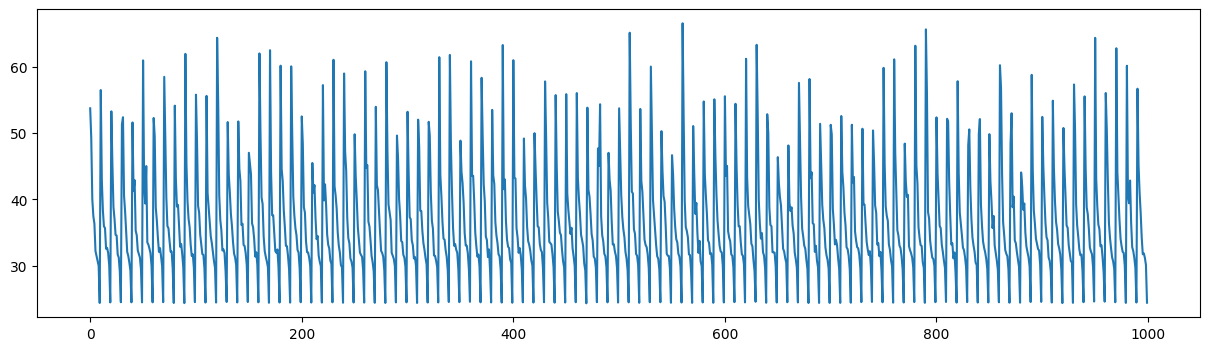

In [7]:
plt.figure(1, figsize=(15, 4))
plt.plot(a)

In [8]:
b = [60.15886688232422,
 58.492584228515625,
 50.50469207763672,
 47.53742980957031,
 45.406982421875,
 41.54552459716797,
 40.92583084106445,
 38.23101806640625,
 35.8779182434082,
 28.881244659423828,
 65.16500854492188,
 53.31147003173828,
 49.77154541015625,
 47.57932662963867,
 42.718597412109375,
 43.36161804199219,
 40.13936996459961,
 38.428199768066406,
 35.63174057006836,
 28.204578399658203,
 64.9665756225586,
 52.38722229003906,
 48.823829650878906,
 46.15728759765625,
 43.28755187988281,
 40.793418884277344,
 37.92374038696289,
 36.67894744873047,
 33.44586181640625,
 26.88435173034668,
 55.77499771118164,
 54.82769012451172,
 49.74396514892578,
 46.15477752685547,
 42.756935119628906,
 40.412872314453125,
 38.779266357421875,
 34.92073059082031,
 32.718997955322266,
 25.92439842224121,
 59.272300720214844,
 49.876739501953125,
 50.8404655456543,
 43.94458770751953,
 41.29179763793945,
 39.01538848876953,
 37.313201904296875,
 34.90687942504883,
 31.585826873779297,
 25.444446563720703,
 67.53655242919922,
 51.75098419189453,
 49.12677001953125,
 46.229225158691406,
 41.228389739990234,
 38.56231689453125,
 36.302711486816406,
 33.6264533996582,
 31.691349029541016,
 24.79172134399414,
 60.875362396240234,
 50.46200180053711,
 47.742942810058594,
 45.470054626464844,
 40.64228820800781,
 37.505615234375,
 35.077842712402344,
 33.91522979736328,
 30.205711364746094,
 24.51375961303711,
 61.52650833129883,
 51.776573181152344,
 46.91429901123047,
 46.702491760253906,
 40.34034729003906,
 37.17030715942383,
 34.24281311035156,
 32.798072814941406,
 30.33866310119629,
 24.217025756835938,
 57.17787551879883,
 51.01570129394531,
 46.79938888549805,
 42.2795524597168,
 39.15254211425781,
 36.26640319824219,
 34.657196044921875,
 32.1094970703125,
 29.248775482177734,
 24.02259063720703,
 58.11758041381836,
 51.62032699584961,
 48.19839859008789,
 43.091468811035156,
 38.2084846496582,
 36.53532791137695,
 33.41474151611328,
 31.920654296875,
 29.347354888916016,
 24.02556800842285,
 59.92682647705078,
 50.520565032958984,
 46.412147521972656,
 41.53093719482422,
 38.10088348388672,
 35.77293395996094,
 33.40589904785156,
 31.87116241455078,
 29.12896728515625,
 23.958723068237305,
 62.200111389160156,
 48.85908508300781,
 46.435691833496094,
 42.030296325683594,
 37.52138137817383,
 35.448707580566406,
 34.60517883300781,
 31.314434051513672,
 28.795623779296875,
 23.74632453918457,
 66.35921478271484,
 50.40361022949219,
 46.179908752441406,
 40.65142822265625,
 37.73300552368164,
 36.30889129638672,
 32.703514099121094,
 31.2960147857666,
 28.464473724365234,
 23.69647216796875,
 60.09760665893555,
 49.57081985473633,
 48.27070236206055,
 40.51515197753906,
 37.257728576660156,
 34.49409484863281,
 32.91277313232422,
 30.495677947998047,
 28.941848754882812,
 23.636940002441406,
 62.11476516723633,
 48.565460205078125,
 47.710716247558594,
 40.3704948425293,
 37.62590026855469,
 34.7345085144043,
 32.529014587402344,
 30.275192260742188,
 28.920814514160156,
 23.533233642578125,
 60.57772445678711,
 49.462501525878906,
 47.748573303222656,
 39.460899353027344,
 36.186065673828125,
 34.66410827636719,
 33.155487060546875,
 29.625568389892578,
 27.649295806884766,
 23.50033187866211,
 59.86595916748047,
 52.529178619384766,
 42.97145080566406,
 41.217987060546875,
 37.101070404052734,
 33.58757781982422,
 32.65793228149414,
 29.69316291809082,
 27.811874389648438,
 23.422706604003906,
 62.476356506347656,
 48.868202209472656,
 46.92761993408203,
 40.311492919921875,
 36.75303268432617,
 34.97099304199219,
 32.37275695800781,
 31.060054779052734,
 27.54245376586914,
 23.35651206970215,
 61.18356704711914,
 55.208412170410156,
 43.963871002197266,
 39.58395767211914,
 37.013641357421875,
 33.41046142578125,
 32.129127502441406,
 29.866764068603516,
 27.042709350585938,
 23.230384826660156,
 63.155479431152344,
 52.49321746826172,
 43.946102142333984,
 39.23948287963867,
 35.23664474487305,
 33.689796447753906,
 32.306880950927734,
 29.781007766723633,
 27.542129516601562,
 23.227025985717773,
 56.40806579589844,
 50.54185485839844,
 44.201271057128906,
 38.76605987548828,
 35.7071418762207,
 32.9873046875,
 32.16758728027344,
 29.491329193115234,
 28.218021392822266,
 23.212892532348633,
 54.45720291137695,
 48.67018127441406,
 45.109336853027344,
 38.18344497680664,
 34.84687042236328,
 34.64617919921875,
 31.312511444091797,
 29.16593360900879,
 26.645051956176758,
 23.09839630126953,
 66.3432388305664,
 49.88555145263672,
 42.876487731933594,
 38.946075439453125,
 35.62342071533203,
 33.535369873046875,
 31.402488708496094,
 28.86095428466797,
 26.80499267578125,
 23.048519134521484,
 61.40067672729492,
 46.87702941894531,
 42.64452362060547,
 40.597618103027344,
 36.24286651611328,
 33.427955627441406,
 30.67733383178711,
 29.567813873291016,
 26.984474182128906,
 23.06590461730957,
 59.34001922607422,
 47.98753356933594,
 43.08571243286133,
 38.74577713012695,
 35.27904510498047,
 32.77290725708008,
 31.509153366088867,
 28.259939193725586,
 26.39696502685547,
 23.054996490478516,
 59.048065185546875,
 49.02423095703125,
 41.64242935180664,
 38.424224853515625,
 36.49462127685547,
 32.97825622558594,
 30.939224243164062,
 29.568790435791016,
 26.4733829498291,
 22.962305068969727,
 63.02875518798828,
 48.914363861083984,
 44.72274398803711,
 38.821372985839844,
 35.41165542602539,
 32.84797668457031,
 30.815013885498047,
 29.400440216064453,
 26.221099853515625,
 22.846302032470703,
 55.601539611816406,
 50.728275299072266,
 41.691253662109375,
 38.662986755371094,
 35.681068420410156,
 33.157501220703125,
 31.024145126342773,
 28.588184356689453,
 26.019222259521484,
 22.800395965576172,
 61.158668518066406,
 51.799346923828125,
 43.41901779174805,
 35.84801483154297,
 36.19895935058594,
 33.06813049316406,
 30.690425872802734,
 29.128585815429688,
 26.377017974853516,
 22.762454986572266,
 63.808006286621094,
 50.96908950805664,
 42.915321350097656,
 39.386268615722656,
 35.345943450927734,
 32.17731475830078,
 30.579299926757812,
 28.87584686279297,
 26.17816162109375,
 22.85650634765625,
 58.41381072998047,
 50.36477279663086,
 43.01802062988281,
 38.349491119384766,
 34.665260314941406,
 32.92763900756836,
 30.463058471679688,
 28.96685028076172,
 26.19175148010254,
 22.828819274902344,
 61.255279541015625,
 50.56692123413086,
 41.612693786621094,
 37.08064270019531,
 35.06630325317383,
 32.19829559326172,
 30.332412719726562,
 28.30014419555664,
 26.190099716186523,
 22.907073974609375,
 61.554664611816406,
 50.643070220947266,
 41.402122497558594,
 36.7314453125,
 34.49839782714844,
 31.94516372680664,
 30.322277069091797,
 28.630239486694336,
 25.66914176940918,
 22.698314666748047,
 59.473899841308594,
 49.76800537109375,
 42.1337890625,
 38.508392333984375,
 33.99441909790039,
 32.760719299316406,
 30.390169143676758,
 28.477798461914062,
 25.58683967590332,
 22.84671401977539,
 57.13597869873047,
 51.97801208496094,
 43.997352600097656,
 36.968162536621094,
 35.557552337646484,
 32.720123291015625,
 30.48227882385254,
 27.893478393554688,
 25.430374145507812,
 22.898231506347656,
 54.00453186035156,
 51.21501541137695,
 40.43582534790039,
 37.92681121826172,
 34.806209564208984,
 31.301925659179688,
 30.227794647216797,
 28.115707397460938,
 25.587631225585938,
 22.840190887451172,
 57.24948501586914,
 50.42259216308594,
 43.394447326660156,
 37.274784088134766,
 35.678489685058594,
 32.15750503540039,
 30.307613372802734,
 28.545074462890625,
 26.107702255249023,
 22.592578887939453,
 58.35340118408203,
 50.71266555786133,
 41.770240783691406,
 37.10234832763672,
 35.401947021484375,
 32.71955871582031,
 30.50566291809082,
 28.146499633789062,
 25.215545654296875,
 22.648366928100586,
 57.20598602294922,
 50.42473220825195,
 44.95752716064453,
 36.68341064453125,
 33.353851318359375,
 31.581653594970703,
 30.585372924804688,
 28.248355865478516,
 25.77532196044922,
 22.541810989379883,
 55.73323059082031,
 50.15379333496094,
 42.56134033203125,
 36.89599609375,
 35.553466796875,
 32.53163146972656,
 29.883834838867188,
 28.428184509277344,
 25.352256774902344,
 22.662660598754883,
 64.04715728759766,
 49.11113739013672,
 41.442527770996094,
 37.992069244384766,
 32.207252502441406,
 31.333518981933594,
 30.74949836730957,
 28.116497039794922,
 25.353389739990234,
 22.908172607421875,
 58.948543548583984,
 51.2761116027832,
 41.10319900512695,
 37.65668869018555,
 33.42356872558594,
 32.58513641357422,
 30.366661071777344,
 27.440385818481445,
 25.824237823486328,
 22.7098388671875,
 55.90788650512695,
 49.423789978027344,
 42.3114013671875,
 37.30473327636719,
 35.694374084472656,
 32.25590515136719,
 30.33565902709961,
 27.953399658203125,
 25.446212768554688,
 22.722991943359375,
 56.98318099975586,
 50.450687408447266,
 40.981224060058594,
 37.633262634277344,
 33.53559494018555,
 33.070289611816406,
 29.646835327148438,
 28.455745697021484,
 24.801237106323242,
 22.652896881103516,
 57.83696365356445,
 49.02826690673828,
 39.959190368652344,
 35.87274932861328,
 33.809234619140625,
 30.866357803344727,
 29.501155853271484,
 27.348133087158203,
 25.245975494384766,
 22.5345401763916,
 64.29063415527344,
 47.930152893066406,
 40.602718353271484,
 37.518409729003906,
 34.24830627441406,
 31.71019744873047,
 30.263160705566406,
 27.947967529296875,
 25.903820037841797,
 22.61491584777832,
 55.52452850341797,
 49.85042190551758,
 40.20854568481445,
 38.2133674621582,
 33.01744079589844,
 31.783992767333984,
 29.44771957397461,
 27.704469680786133,
 25.046546936035156,
 22.653160095214844,
 59.42668914794922,
 46.8970947265625,
 42.563560485839844,
 35.53432846069336,
 33.04492950439453,
 30.67733383178711,
 29.853179931640625,
 28.24847984313965,
 25.280986785888672,
 22.580293655395508,
 50.927738189697266,
 50.32697296142578,
 42.571434020996094,
 36.78934097290039,
 34.00768280029297,
 32.274658203125,
 30.47831153869629,
 27.437911987304688,
 25.315383911132812,
 22.468032836914062,
 56.35257339477539,
 47.0963020324707,
 39.86248779296875,
 37.41697692871094,
 32.65816879272461,
 32.27876663208008,
 29.788707733154297,
 27.74923324584961,
 25.283573150634766,
 22.56320571899414,
 58.20149230957031,
 46.195533752441406,
 39.06304931640625,
 36.616600036621094,
 33.22996520996094,
 31.29818344116211,
 29.57168197631836,
 27.273880004882812,
 24.787967681884766,
 22.346752166748047,
 61.34805679321289,
 50.08772277832031,
 41.81059265136719,
 39.338417053222656,
 32.93157958984375,
 31.428503036499023,
 28.974576950073242,
 26.90667724609375,
 25.024417877197266,
 22.318025588989258,
 53.6441535949707,
 45.87464904785156,
 41.58671569824219,
 36.06616973876953,
 33.585208892822266,
 31.649890899658203,
 29.742019653320312,
 27.283992767333984,
 24.99681854248047,
 22.43163299560547,
 55.4619026184082,
 48.113121032714844,
 40.536067962646484,
 36.32584762573242,
 34.33461380004883,
 31.380046844482422,
 29.724998474121094,
 27.211198806762695,
 25.090715408325195,
 22.435752868652344,
 50.88736343383789,
 46.65945816040039,
 39.789649963378906,
 36.8917236328125,
 33.4351692199707,
 31.640962600708008,
 30.340099334716797,
 27.092065811157227,
 24.744232177734375,
 22.421005249023438,
 62.474483489990234,
 49.33662414550781,
 40.596397399902344,
 35.6864128112793,
 35.10958480834961,
 31.4382381439209,
 29.61888885498047,
 27.893356323242188,
 24.897071838378906,
 22.281513214111328,
 62.65290451049805,
 51.752044677734375,
 39.82534408569336,
 36.863914489746094,
 33.60163116455078,
 32.071475982666016,
 29.02215576171875,
 27.106788635253906,
 24.86867904663086,
 22.465545654296875,
 55.53008270263672,
 44.31013488769531,
 39.92591857910156,
 34.662837982177734,
 33.33051681518555,
 31.142868041992188,
 29.79547882080078,
 27.028186798095703,
 25.24878692626953,
 22.46979522705078,
 61.11489486694336,
 45.91014862060547,
 39.43116760253906,
 35.31767654418945,
 33.09783172607422,
 30.728755950927734,
 29.368946075439453,
 27.424388885498047,
 24.41547393798828,
 22.270917892456055,
 54.48772430419922,
 48.37245559692383,
 39.88894271850586,
 36.72517776489258,
 32.98355484008789,
 31.596406936645508,
 30.369548797607422,
 27.265605926513672,
 24.82449722290039,
 22.280546188354492,
 61.77357482910156,
 49.669097900390625,
 41.45454406738281,
 35.78514862060547,
 32.776363372802734,
 31.073074340820312,
 28.92325210571289,
 26.913204193115234,
 24.216846466064453,
 22.41862678527832,
 51.31232452392578,
 47.813819885253906,
 38.79612731933594,
 37.0207405090332,
 32.44336700439453,
 31.52110481262207,
 29.31859588623047,
 27.312015533447266,
 24.594087600708008,
 22.397064208984375,
 62.238739013671875,
 49.99417495727539,
 41.119789123535156,
 36.02751159667969,
 32.93585968017578,
 30.549840927124023,
 29.311840057373047,
 26.93622589111328,
 24.208242416381836,
 22.206298828125,
 62.091819763183594,
 53.30084991455078,
 40.711639404296875,
 36.855926513671875,
 33.49242401123047,
 31.49740219116211,
 28.82086181640625,
 27.080644607543945,
 24.653831481933594,
 22.302125930786133,
 52.90895080566406,
 50.14942169189453,
 38.98631286621094,
 36.119903564453125,
 33.072608947753906,
 31.564451217651367,
 29.864437103271484,
 27.03067398071289,
 24.257762908935547,
 22.267711639404297,
 56.92115783691406,
 48.306549072265625,
 40.032562255859375,
 37.00981521606445,
 33.63542175292969,
 31.4385986328125,
 29.059032440185547,
 27.045276641845703,
 24.482284545898438,
 22.206445693969727,
 54.662620544433594,
 47.38694381713867,
 38.65226745605469,
 35.727142333984375,
 33.39265441894531,
 31.2764892578125,
 29.06732940673828,
 26.70815658569336,
 23.98977279663086,
 22.235774993896484,
 61.22075653076172,
 46.54511642456055,
 38.919456481933594,
 35.851470947265625,
 32.28950881958008,
 31.17259979248047,
 29.204830169677734,
 26.542293548583984,
 24.720111846923828,
 22.090335845947266,
 56.32794952392578,
 49.20178985595703,
 40.25955581665039,
 35.336002349853516,
 32.80286407470703,
 31.413410186767578,
 28.779958724975586,
 26.628488540649414,
 23.91840362548828,
 22.145177841186523,
 58.89945983886719,
 46.36239242553711,
 41.74261474609375,
 34.74216842651367,
 32.816646575927734,
 30.538578033447266,
 29.167036056518555,
 26.856481552124023,
 24.000568389892578,
 21.998641967773438,
 52.687591552734375,
 45.589942932128906,
 37.02166748046875,
 36.18464660644531,
 32.96267318725586,
 29.896337509155273,
 28.738712310791016,
 26.94963836669922,
 24.249853134155273,
 22.216217041015625,
 58.35847091674805,
 47.13471221923828,
 39.82379913330078,
 35.43450164794922,
 32.5853385925293,
 31.32093048095703,
 29.151241302490234,
 26.592456817626953,
 23.96966552734375,
 22.1153564453125,
 63.95804214477539,
 47.20094299316406,
 41.26215744018555,
 35.60688781738281,
 33.58709716796875,
 30.822887420654297,
 29.043968200683594,
 26.75421905517578,
 24.280345916748047,
 22.234779357910156,
 53.96103286743164,
 45.73031234741211,
 39.22798156738281,
 36.12604522705078,
 32.703338623046875,
 31.195472717285156,
 29.8480224609375,
 26.84377098083496,
 24.36673927307129,
 22.06683921813965,
 52.067420959472656,
 50.00614929199219,
 39.13087844848633,
 35.057029724121094,
 32.63298416137695,
 31.145401000976562,
 28.591800689697266,
 26.712142944335938,
 24.18296241760254,
 21.989723205566406,
 56.889808654785156,
 45.86555480957031,
 37.83641052246094,
 35.12388610839844,
 32.08834457397461,
 30.430400848388672,
 28.548458099365234,
 26.95541763305664,
 24.483627319335938,
 21.96988296508789,
 57.26782989501953,
 46.78197479248047,
 38.350494384765625,
 34.27931213378906,
 32.300785064697266,
 30.17224884033203,
 29.671377182006836,
 26.614501953125,
 24.607086181640625,
 22.031709671020508,
 54.438148498535156,
 50.552555084228516,
 38.62794494628906,
 35.61140441894531,
 32.028465270996094,
 30.24261474609375,
 28.31493377685547,
 26.89044952392578,
 24.130714416503906,
 21.827627182006836,
 55.392677307128906,
 48.27275848388672,
 38.31258773803711,
 34.37173080444336,
 31.974401473999023,
 30.616233825683594,
 28.398765563964844,
 26.96523666381836,
 24.522335052490234,
 22.039875030517578,
 59.218807220458984,
 53.70046615600586,
 38.1405029296875,
 33.853546142578125,
 31.954727172851562,
 29.992691040039062,
 28.522991180419922,
 26.929166793823242,
 24.046852111816406,
 21.902111053466797,
 57.804691314697266,
 49.28132629394531,
 39.45844650268555,
 36.53713607788086,
 32.913597106933594,
 30.023019790649414,
 28.383487701416016,
 26.496591567993164,
 23.882009506225586,
 22.00204086303711,
 59.905433654785156,
 47.816410064697266,
 40.443267822265625,
 35.678871154785156,
 32.14755630493164,
 30.63101577758789,
 28.68075180053711,
 26.755725860595703,
 24.2530517578125,
 21.938129425048828,
 57.305076599121094,
 46.386680603027344,
 38.323402404785156,
 34.442626953125,
 32.695247650146484,
 30.15892791748047,
 28.682771682739258,
 26.31159782409668,
 24.02254295349121,
 22.1261043548584,
 50.6920166015625,
 45.53132629394531,
 41.3817253112793,
 36.019535064697266,
 32.40094757080078,
 30.488576889038086,
 28.674161911010742,
 26.429229736328125,
 24.299083709716797,
 21.88043212890625,
 59.24551773071289,
 46.925193786621094,
 38.627784729003906,
 34.42848205566406,
 32.401123046875,
 29.725631713867188,
 28.888622283935547,
 26.28567886352539,
 24.05858612060547,
 21.912199020385742,
 57.55510711669922,
 43.67827606201172,
 39.37664031982422,
 34.70183181762695,
 31.97438621520996,
 30.1912841796875,
 28.416671752929688,
 25.864173889160156,
 23.615623474121094,
 21.968486785888672,
 51.73430633544922,
 45.788063049316406,
 39.01538848876953,
 34.75185775756836,
 32.33308410644531,
 30.206111907958984,
 28.88534927368164,
 26.835525512695312,
 24.12548828125,
 21.85065269470215,
 54.663841247558594,
 46.55226135253906,
 39.636749267578125,
 35.204559326171875,
 31.7354679107666,
 30.38306427001953,
 28.822717666625977,
 26.51742935180664,
 23.994178771972656,
 21.84731674194336,
 52.87997055053711,
 46.126651763916016,
 38.3731689453125,
 33.66502380371094,
 33.12919616699219,
 30.17153549194336,
 28.950977325439453,
 26.63713836669922,
 24.306581497192383,
 21.884857177734375,
 57.642372131347656,
 47.17243194580078,
 39.345367431640625,
 33.620723724365234,
 31.70538902282715,
 29.422061920166016,
 28.82491683959961,
 26.447216033935547,
 24.297874450683594,
 21.97418785095215,
 58.723182678222656,
 44.24028396606445,
 39.05967712402344,
 34.53594970703125,
 31.223281860351562,
 29.728498458862305,
 27.794658660888672,
 25.94247055053711,
 23.541301727294922,
 21.780006408691406,
 54.206451416015625,
 44.46261978149414,
 38.344200134277344,
 35.03423309326172,
 31.312280654907227,
 30.396100997924805,
 28.557987213134766,
 26.42591094970703,
 23.82150650024414,
 21.88656234741211,
 52.64704895019531,
 48.54312515258789,
 39.38702392578125,
 33.7480583190918,
 31.769012451171875,
 30.062715530395508,
 28.259538650512695,
 26.449054718017578,
 23.693519592285156,
 21.74660301208496,
 57.31061553955078,
 50.38628387451172,
 39.25143051147461,
 34.50664138793945,
 31.838594436645508,
 30.394912719726562,
 28.28936004638672,
 26.795085906982422,
 23.746997833251953,
 21.865890502929688,
 49.34770202636719,
 51.31922912597656,
 38.89080047607422,
 34.17805099487305,
 31.994598388671875,
 30.033592224121094,
 28.864742279052734,
 25.586557388305664,
 23.83759307861328,
 21.835519790649414,
 55.46467590332031,
 46.240882873535156,
 37.937705993652344,
 33.44408416748047,
 31.974124908447266,
 30.725269317626953,
 28.369640350341797,
 26.78311538696289,
 23.770492553710938,
 21.78293800354004,
 57.74078369140625,
 46.15363693237305,
 39.175079345703125,
 34.447425842285156,
 31.297842025756836,
 30.659576416015625,
 28.39562225341797,
 26.382802963256836,
 23.965316772460938,
 21.88759994506836,
 66.342529296875,
 47.83708572387695,
 38.6692008972168,
 34.424644470214844,
 31.94231605529785,
 30.123741149902344,
 28.186267852783203,
 26.519363403320312,
 24.17282485961914,
 21.741003036499023,
 56.18804168701172,
 47.69270324707031,
 38.60500717163086,
 34.71139907836914,
 31.87398910522461,
 29.490591049194336,
 28.305444717407227,
 26.190528869628906,
 23.823957443237305,
 21.704891204833984,
 54.3348274230957,
 47.78483200073242,
 37.528541564941406,
 32.946231842041016,
 31.083702087402344,
 30.060348510742188,
 28.842573165893555,
 26.914432525634766,
 24.33599853515625,
 21.735464096069336]

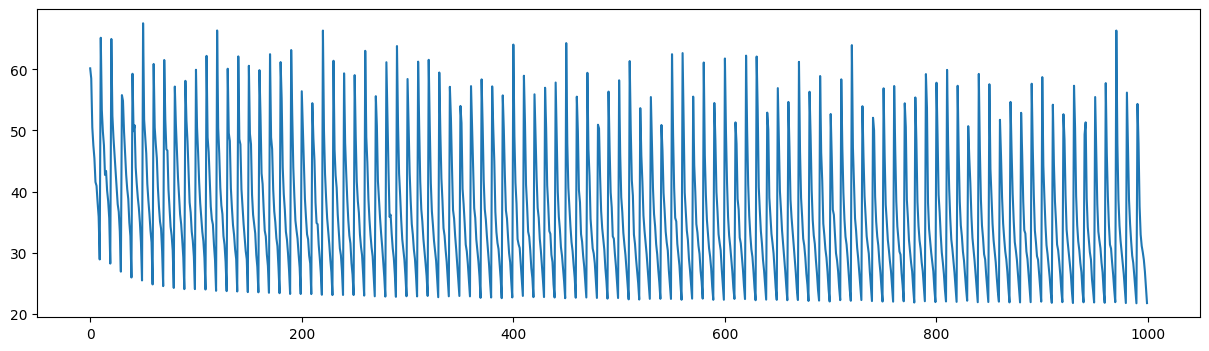

In [9]:
plt.figure(1, figsize=(15, 4))
plt.plot(b)

In [10]:
c = [62.58863067626953,
 62.537052154541016,
 61.139373779296875,
 61.911354064941406,
 61.600311279296875,
 59.62970733642578,
 56.673004150390625,
 54.17412185668945,
 49.96257781982422,
 37.7481575012207,
 62.262271881103516,
 62.66887664794922,
 61.037269592285156,
 60.25013732910156,
 59.31070327758789,
 58.63683319091797,
 55.33847427368164,
 53.48492431640625,
 49.049468994140625,
 36.79090881347656,
 62.47010803222656,
 62.16979217529297,
 58.347564697265625,
 59.469600677490234,
 60.14972686767578,
 58.102684020996094,
 55.0073356628418,
 52.1664924621582,
 48.39021301269531,
 36.005035400390625,
 62.81227493286133,
 62.63991165161133,
 59.466957092285156,
 59.947086334228516,
 59.33815383911133,
 58.14447784423828,
 54.760948181152344,
 51.24894714355469,
 47.55029296875,
 35.34714889526367,
 62.609710693359375,
 61.53968811035156,
 60.42570495605469,
 60.668792724609375,
 58.61994171142578,
 57.1626091003418,
 54.3240852355957,
 51.24760055541992,
 46.81757354736328,
 34.778221130371094,
 62.987030029296875,
 62.24077606201172,
 60.529788970947266,
 59.815608978271484,
 58.26250457763672,
 56.96060562133789,
 53.948272705078125,
 50.46246337890625,
 46.07673263549805,
 34.19761657714844,
 62.6754264831543,
 62.01042175292969,
 60.65873718261719,
 58.90230178833008,
 57.21147537231445,
 55.728885650634766,
 52.727638244628906,
 49.365386962890625,
 45.572731018066406,
 33.68688201904297,
 62.87635803222656,
 62.08417510986328,
 60.67938232421875,
 57.92137145996094,
 57.77808380126953,
 55.707862854003906,
 52.74449920654297,
 49.503578186035156,
 44.45417022705078,
 33.3249626159668,
 63.37256622314453,
 62.867958068847656,
 61.35014343261719,
 58.40013885498047,
 57.28274154663086,
 54.66248321533203,
 51.55928039550781,
 48.51710510253906,
 43.85636520385742,
 32.88587188720703,
 63.001182556152344,
 63.63639450073242,
 60.69114685058594,
 58.4616584777832,
 56.343994140625,
 54.31259536743164,
 51.979183197021484,
 47.57561111450195,
 43.80602264404297,
 32.72273254394531,
 63.632530212402344,
 62.759918212890625,
 60.84062194824219,
 58.66455841064453,
 56.75745391845703,
 54.808815002441406,
 50.40635681152344,
 47.575557708740234,
 43.29720687866211,
 32.46684265136719,
 63.206539154052734,
 63.513038635253906,
 60.40753173828125,
 58.551780700683594,
 56.253807067871094,
 54.686553955078125,
 50.492950439453125,
 47.44624328613281,
 43.252140045166016,
 32.32759094238281,
 63.16648483276367,
 63.238521575927734,
 60.09831237792969,
 58.509056091308594,
 56.05708694458008,
 54.17450714111328,
 50.49827575683594,
 46.35329818725586,
 42.85047912597656,
 32.02883529663086,
 64.43855285644531,
 63.04538345336914,
 60.66041564941406,
 58.75394058227539,
 54.89598083496094,
 52.613555908203125,
 49.93463134765625,
 46.656368255615234,
 42.59718322753906,
 31.799392700195312,
 62.91400146484375,
 61.965152740478516,
 60.841922760009766,
 57.426246643066406,
 56.15364074707031,
 52.17903137207031,
 50.28968048095703,
 46.34503936767578,
 42.533931732177734,
 31.595684051513672,
 63.043670654296875,
 63.23631286621094,
 58.89701843261719,
 58.217620849609375,
 55.12582778930664,
 52.22549057006836,
 49.903465270996094,
 46.08990478515625,
 42.01533508300781,
 31.382366180419922,
 62.92959976196289,
 63.60057067871094,
 60.206539154052734,
 56.51506805419922,
 55.3856086730957,
 51.32554244995117,
 49.18836212158203,
 46.12096405029297,
 42.211952209472656,
 31.261104583740234,
 62.04735565185547,
 61.07073974609375,
 60.42375946044922,
 56.084556579589844,
 54.8477783203125,
 52.463829040527344,
 48.58173751831055,
 46.394309997558594,
 42.01298522949219,
 31.080974578857422,
 63.08953857421875,
 62.13608169555664,
 60.83268356323242,
 56.90972900390625,
 54.96623229980469,
 52.02607727050781,
 49.14829635620117,
 45.82596969604492,
 41.969337463378906,
 30.960527420043945,
 62.647315979003906,
 61.8114128112793,
 60.63188171386719,
 58.109615325927734,
 54.254981994628906,
 51.69672393798828,
 48.550743103027344,
 45.56257629394531,
 41.6763801574707,
 30.878963470458984,
 62.58134460449219,
 62.02939224243164,
 58.2877197265625,
 57.792842864990234,
 54.42243957519531,
 51.718650817871094,
 48.80344009399414,
 45.317623138427734,
 41.60001754760742,
 30.729354858398438,
 62.127716064453125,
 63.472347259521484,
 59.851661682128906,
 57.398033142089844,
 54.477664947509766,
 51.009483337402344,
 48.85101318359375,
 45.12579345703125,
 41.46720886230469,
 30.63850212097168,
 62.70996856689453,
 62.326751708984375,
 61.73780822753906,
 57.238914489746094,
 53.69166946411133,
 50.15487289428711,
 48.091915130615234,
 45.510528564453125,
 41.39548873901367,
 30.51712417602539,
 62.3754997253418,
 62.6180534362793,
 61.246788024902344,
 56.949459075927734,
 53.95918273925781,
 50.617122650146484,
 47.846412658691406,
 45.12316131591797,
 41.432464599609375,
 30.412199020385742,
 62.89234924316406,
 62.29151153564453,
 60.11517333984375,
 57.385498046875,
 53.46820831298828,
 50.90345764160156,
 47.77092742919922,
 44.840938568115234,
 41.352272033691406,
 30.378677368164062,
 62.11491394042969,
 63.22953414916992,
 58.766265869140625,
 55.12473678588867,
 53.76640319824219,
 50.82428741455078,
 47.4791374206543,
 44.87535095214844,
 41.17052459716797,
 30.358463287353516,
 62.540061950683594,
 62.36097717285156,
 59.77936935424805,
 56.171607971191406,
 53.1132698059082,
 50.163246154785156,
 47.44197082519531,
 44.90369415283203,
 41.302833557128906,
 30.31756591796875,
 63.19195556640625,
 63.48308563232422,
 59.71329116821289,
 56.75608825683594,
 53.367042541503906,
 50.77330780029297,
 47.90137481689453,
 44.83164978027344,
 41.12593078613281,
 30.282363891601562,
 62.502037048339844,
 63.07057189941406,
 57.1133918762207,
 57.63932418823242,
 53.67951965332031,
 50.09294891357422,
 47.369808197021484,
 44.910377502441406,
 41.00363540649414,
 30.222612380981445,
 63.518287658691406,
 62.41453552246094,
 58.65428161621094,
 56.581993103027344,
 51.96045684814453,
 49.490089416503906,
 47.00895690917969,
 44.34610366821289,
 40.939064025878906,
 30.184011459350586,
 62.75440216064453,
 62.64471435546875,
 58.914520263671875,
 55.437862396240234,
 52.93324661254883,
 49.86749267578125,
 47.13543701171875,
 43.840728759765625,
 41.05561828613281,
 30.09343719482422,
 62.878875732421875,
 60.331642150878906,
 59.08062744140625,
 55.447731018066406,
 52.47105407714844,
 49.75194549560547,
 47.22100830078125,
 44.30883026123047,
 40.916622161865234,
 30.031038284301758,
 62.34380340576172,
 62.014442443847656,
 60.6041259765625,
 54.64780044555664,
 53.23155975341797,
 49.56227111816406,
 47.02744674682617,
 44.69641876220703,
 40.77616882324219,
 29.999900817871094,
 62.556488037109375,
 60.89888000488281,
 56.623268127441406,
 55.95552062988281,
 52.49958801269531,
 49.226253509521484,
 46.806243896484375,
 43.803680419921875,
 40.70875930786133,
 29.933870315551758,
 63.09055709838867,
 62.865901947021484,
 59.739036560058594,
 54.790077209472656,
 52.83728790283203,
 49.069435119628906,
 46.33099365234375,
 44.03750991821289,
 40.85970687866211,
 29.871967315673828,
 62.082069396972656,
 61.07710266113281,
 58.010921478271484,
 55.72802734375,
 52.22156524658203,
 48.836524963378906,
 46.427982330322266,
 44.46424865722656,
 40.49013137817383,
 29.754592895507812,
 62.54288101196289,
 62.764137268066406,
 59.79796600341797,
 55.788116455078125,
 51.864742279052734,
 49.08621597290039,
 46.55187225341797,
 44.296669006347656,
 40.48400115966797,
 29.67812156677246,
 62.63394546508789,
 62.93538284301758,
 60.32444381713867,
 55.677772521972656,
 52.75084686279297,
 49.92776870727539,
 46.14073181152344,
 44.50657653808594,
 40.70865249633789,
 29.609577178955078,
 62.53116989135742,
 62.275665283203125,
 58.270362854003906,
 55.7493896484375,
 52.41687774658203,
 49.28650665283203,
 46.10814666748047,
 44.07573699951172,
 40.531402587890625,
 29.51626205444336,
 62.400550842285156,
 62.334224700927734,
 58.58958435058594,
 55.52872848510742,
 52.030235290527344,
 49.37828063964844,
 45.900569915771484,
 43.98846435546875,
 40.29126739501953,
 29.4472599029541,
 61.96387481689453,
 61.892723083496094,
 57.234962463378906,
 55.25443649291992,
 51.66647720336914,
 48.363773345947266,
 46.00587844848633,
 43.547157287597656,
 40.48405456542969,
 29.437637329101562,
 63.51137924194336,
 62.11188507080078,
 59.61902618408203,
 54.81354522705078,
 51.59930419921875,
 48.71215057373047,
 46.144386291503906,
 43.9331169128418,
 40.50579833984375,
 29.331581115722656,
 62.27268981933594,
 63.49348068237305,
 58.882568359375,
 55.72510528564453,
 52.326820373535156,
 48.30259323120117,
 45.89186477661133,
 43.832489013671875,
 40.172542572021484,
 29.295089721679688,
 62.722957611083984,
 60.811309814453125,
 58.996456146240234,
 55.464569091796875,
 51.57147216796875,
 48.54718780517578,
 46.43769836425781,
 43.52374267578125,
 40.14569091796875,
 29.235319137573242,
 63.50067138671875,
 62.072593688964844,
 58.65845489501953,
 54.26310729980469,
 52.31524658203125,
 48.37896728515625,
 45.95465850830078,
 43.792022705078125,
 40.10979461669922,
 29.195594787597656,
 62.531776428222656,
 61.75901412963867,
 58.5856819152832,
 54.347869873046875,
 51.69123077392578,
 48.82422637939453,
 45.78816223144531,
 43.64459228515625,
 39.887630462646484,
 29.176280975341797,
 62.304412841796875,
 61.236785888671875,
 58.14891815185547,
 54.43965148925781,
 51.66539001464844,
 48.04082107543945,
 46.10337829589844,
 43.983543395996094,
 39.9884147644043,
 29.159008026123047,
 61.92076873779297,
 62.360469818115234,
 58.31620407104492,
 54.46918487548828,
 51.60357666015625,
 48.33929443359375,
 45.7443962097168,
 43.70588684082031,
 39.81263732910156,
 29.157358169555664,
 63.038692474365234,
 61.17488098144531,
 58.92767333984375,
 54.4332389831543,
 50.815284729003906,
 48.3487663269043,
 45.967533111572266,
 43.33135223388672,
 39.52682113647461,
 29.071979522705078,
 62.56187438964844,
 62.38904571533203,
 57.43043518066406,
 54.45475387573242,
 51.66196823120117,
 48.226470947265625,
 45.37004470825195,
 43.614601135253906,
 39.83199691772461,
 29.061752319335938,
 62.538639068603516,
 62.03166198730469,
 55.819488525390625,
 54.45164108276367,
 51.191551208496094,
 48.719207763671875,
 45.444026947021484,
 43.44552230834961,
 39.64875793457031,
 28.97309112548828,
 63.27715301513672,
 60.436012268066406,
 58.03644943237305,
 53.613983154296875,
 51.36857604980469,
 48.027008056640625,
 45.206642150878906,
 43.47032165527344,
 39.596858978271484,
 28.970462799072266,
 62.29423141479492,
 60.344085693359375,
 57.42115020751953,
 53.503440856933594,
 51.056785583496094,
 48.044654846191406,
 45.227630615234375,
 43.39049530029297,
 39.78956604003906,
 28.955793380737305,
 63.555328369140625,
 60.845787048339844,
 58.64305877685547,
 53.74652099609375,
 51.17802810668945,
 47.90971374511719,
 45.89373779296875,
 43.51762390136719,
 39.732818603515625,
 28.900447845458984,
 62.06441116333008,
 59.72069549560547,
 57.741188049316406,
 54.636749267578125,
 51.12588119506836,
 47.8904914855957,
 45.706939697265625,
 42.982643127441406,
 39.712867736816406,
 28.913719177246094,
 62.856689453125,
 62.263816833496094,
 56.50541687011719,
 53.09954833984375,
 50.8664436340332,
 48.1904182434082,
 45.87063217163086,
 43.46156692504883,
 39.366416931152344,
 28.912433624267578,
 62.096519470214844,
 62.58848190307617,
 56.655731201171875,
 54.387794494628906,
 50.06397247314453,
 47.78083801269531,
 45.298736572265625,
 43.3772087097168,
 39.48981475830078,
 28.885726928710938,
 62.55083465576172,
 61.980369567871094,
 57.19755935668945,
 53.64366149902344,
 50.7092399597168,
 47.35739517211914,
 45.423057556152344,
 43.16284942626953,
 39.735511779785156,
 28.85655975341797,
 63.14764404296875,
 60.17219543457031,
 55.86302185058594,
 53.73625946044922,
 51.64067840576172,
 47.87506103515625,
 45.010066986083984,
 43.21040344238281,
 39.34929656982422,
 28.816669464111328,
 62.36077880859375,
 60.978355407714844,
 58.0007209777832,
 54.63601303100586,
 51.34497833251953,
 47.59193420410156,
 45.067901611328125,
 42.908607482910156,
 39.2965087890625,
 28.733076095581055,
 62.52145004272461,
 61.70874786376953,
 58.410850524902344,
 52.88268280029297,
 50.53961181640625,
 47.95692825317383,
 45.68273162841797,
 43.06996154785156,
 39.0291862487793,
 28.735008239746094,
 63.784278869628906,
 60.84706115722656,
 57.290550231933594,
 54.3394775390625,
 50.259239196777344,
 47.86957550048828,
 45.2100715637207,
 43.19871520996094,
 39.39872741699219,
 28.76787757873535,
 63.06078338623047,
 60.41863250732422,
 58.84381103515625,
 55.64692306518555,
 50.54787063598633,
 47.348426818847656,
 45.24568176269531,
 42.6339111328125,
 39.02914810180664,
 28.741241455078125,
 62.96875762939453,
 61.317867279052734,
 57.398597717285156,
 52.710960388183594,
 50.68846130371094,
 47.26905059814453,
 45.052555084228516,
 42.77493667602539,
 38.970638275146484,
 28.709835052490234,
 62.44151306152344,
 60.71630096435547,
 56.06834411621094,
 53.48678970336914,
 50.76203155517578,
 47.535675048828125,
 45.61724853515625,
 42.779788970947266,
 39.142913818359375,
 28.694480895996094,
 62.39373779296875,
 62.04267883300781,
 57.966331481933594,
 53.642921447753906,
 50.10657501220703,
 47.19147491455078,
 44.75701904296875,
 42.844810485839844,
 39.00424575805664,
 28.687332153320312,
 63.15814971923828,
 61.01087951660156,
 55.5426139831543,
 53.083274841308594,
 51.48033142089844,
 47.50135803222656,
 44.49103927612305,
 42.70063781738281,
 39.02031326293945,
 28.631675720214844,
 63.09333038330078,
 60.68867111206055,
 56.41522979736328,
 53.433929443359375,
 49.992862701416016,
 47.585330963134766,
 44.90535354614258,
 42.84821319580078,
 38.902626037597656,
 28.57693099975586,
 62.5788459777832,
 59.664329528808594,
 56.86273956298828,
 54.99524688720703,
 49.673011779785156,
 47.387603759765625,
 44.64344024658203,
 42.77730178833008,
 39.243412017822266,
 28.603130340576172,
 62.75716781616211,
 60.96792984008789,
 57.07919692993164,
 54.060951232910156,
 50.2703742980957,
 47.504520416259766,
 45.242774963378906,
 43.05457305908203,
 39.078773498535156,
 28.54248046875,
 63.20915222167969,
 61.97813415527344,
 56.10614013671875,
 53.58428955078125,
 50.55890655517578,
 46.852264404296875,
 44.433555603027344,
 42.3814697265625,
 38.92366027832031,
 28.479408264160156,
 62.05687713623047,
 60.81061553955078,
 56.933876037597656,
 53.905845642089844,
 50.55085754394531,
 47.59282302856445,
 44.777435302734375,
 42.39596939086914,
 38.86023712158203,
 28.477252960205078,
 62.4512939453125,
 60.58879852294922,
 57.22206115722656,
 53.92407989501953,
 49.954586029052734,
 47.34140396118164,
 44.551902770996094,
 42.83280944824219,
 38.6695556640625,
 28.467391967773438,
 61.9511604309082,
 60.20115661621094,
 56.8294563293457,
 53.834495544433594,
 50.47211456298828,
 47.99040985107422,
 44.98045349121094,
 42.55882263183594,
 38.80756759643555,
 28.441875457763672,
 62.1673469543457,
 62.17386245727539,
 57.89841079711914,
 53.6622200012207,
 49.564422607421875,
 47.22149658203125,
 45.210174560546875,
 42.65217971801758,
 38.79496765136719,
 28.393325805664062,
 62.74163818359375,
 60.649375915527344,
 55.09217071533203,
 54.22026062011719,
 50.11985778808594,
 47.35691452026367,
 44.940284729003906,
 42.664337158203125,
 38.73395538330078,
 28.399871826171875,
 61.908931732177734,
 62.107574462890625,
 55.3226318359375,
 52.784725189208984,
 49.920928955078125,
 47.72575759887695,
 44.8729133605957,
 42.411705017089844,
 38.562400817871094,
 28.347503662109375,
 62.999420166015625,
 60.942466735839844,
 57.323486328125,
 53.840858459472656,
 50.19025421142578,
 46.68098449707031,
 44.97420120239258,
 42.30442810058594,
 38.52294921875,
 28.34675407409668,
 62.86384582519531,
 60.90309143066406,
 55.52855682373047,
 53.24058532714844,
 50.26177215576172,
 46.950382232666016,
 44.33671569824219,
 42.297645568847656,
 38.619911193847656,
 28.316543579101562,
 63.640625,
 62.0826301574707,
 56.86882781982422,
 54.70249938964844,
 50.276939392089844,
 46.69781494140625,
 44.992225646972656,
 41.872344970703125,
 38.68026351928711,
 28.30508041381836,
 61.545101165771484,
 60.84635925292969,
 56.12181091308594,
 53.68501281738281,
 50.53852081298828,
 47.53386306762695,
 45.02801513671875,
 42.00526428222656,
 38.57794189453125,
 28.3121337890625,
 63.02825927734375,
 60.57056427001953,
 55.646827697753906,
 53.72780990600586,
 49.96907424926758,
 46.874820709228516,
 44.78125762939453,
 42.36320114135742,
 38.52531433105469,
 28.323814392089844,
 63.099971771240234,
 60.393043518066406,
 55.938690185546875,
 53.78193664550781,
 50.018592834472656,
 46.82304382324219,
 44.55950164794922,
 42.15453338623047,
 38.733131408691406,
 28.27039337158203,
 62.744327545166016,
 60.4085807800293,
 56.58394241333008,
 52.602684020996094,
 50.29508972167969,
 47.88897705078125,
 44.755104064941406,
 41.930076599121094,
 38.430091857910156,
 28.220638275146484,
 62.127052307128906,
 59.17979049682617,
 58.06836700439453,
 53.47276306152344,
 50.44175720214844,
 47.21910095214844,
 45.1929817199707,
 42.64672088623047,
 38.679359436035156,
 28.214202880859375,
 63.05101013183594,
 58.8374137878418,
 54.45531463623047,
 53.60025405883789,
 49.49810028076172,
 46.834510803222656,
 44.74828338623047,
 42.28440856933594,
 38.434303283691406,
 28.18267822265625,
 61.9891242980957,
 62.047386169433594,
 57.13874816894531,
 52.8818473815918,
 50.244346618652344,
 46.89082336425781,
 44.821922302246094,
 42.099700927734375,
 38.496543884277344,
 28.138898849487305,
 61.22395324707031,
 62.247901916503906,
 56.25413131713867,
 53.12037658691406,
 49.981075286865234,
 46.71820831298828,
 44.84111404418945,
 41.99903106689453,
 38.146183013916016,
 28.14835548400879,
 62.8581657409668,
 61.38932800292969,
 56.20939636230469,
 54.24073028564453,
 49.540489196777344,
 47.09552764892578,
 45.040828704833984,
 42.25236511230469,
 38.21779251098633,
 28.14324188232422,
 62.78203201293945,
 61.205787658691406,
 56.1371955871582,
 53.396568298339844,
 50.41233825683594,
 46.8214111328125,
 44.91474151611328,
 41.944419860839844,
 38.482093811035156,
 28.1038875579834,
 62.496612548828125,
 57.682090759277344,
 56.369388580322266,
 52.624549865722656,
 50.03968048095703,
 47.24383544921875,
 44.053741455078125,
 41.93568420410156,
 38.39734649658203,
 28.087108612060547,
 63.644004821777344,
 58.26072692871094,
 56.473388671875,
 53.44304656982422,
 49.69563293457031,
 47.260589599609375,
 44.30262756347656,
 41.91791534423828,
 38.44414520263672,
 28.0802059173584,
 62.065460205078125,
 59.48444747924805,
 55.974281311035156,
 53.84263610839844,
 49.5268669128418,
 46.667972564697266,
 44.67530059814453,
 41.983673095703125,
 38.44152069091797,
 28.121944427490234,
 62.58154296875,
 59.51271057128906,
 57.436500549316406,
 52.9589729309082,
 49.975196838378906,
 46.8511962890625,
 44.334529876708984,
 41.712852478027344,
 38.34157943725586,
 28.149658203125,
 62.221435546875,
 59.749855041503906,
 56.827003479003906,
 53.255592346191406,
 49.65007781982422,
 47.871646881103516,
 44.51717758178711,
 41.99073791503906,
 38.29485321044922,
 28.14529800415039,
 64.19243621826172,
 58.97840881347656,
 56.24905014038086,
 53.67070388793945,
 50.12944793701172,
 47.2342529296875,
 44.61422348022461,
 42.058494567871094,
 38.53969955444336,
 28.121150970458984,
 62.80648422241211,
 59.05096435546875,
 56.10707092285156,
 52.980613708496094,
 49.43354034423828,
 47.746673583984375,
 44.06604766845703,
 42.117347717285156,
 38.37386703491211,
 28.03601837158203,
 61.41792297363281,
 59.935001373291016,
 55.093231201171875,
 53.117496490478516,
 50.719017028808594,
 46.921043395996094,
 45.0423469543457,
 42.091007232666016,
 38.21508026123047,
 28.05166244506836,
 61.77050018310547,
 60.6125373840332,
 54.19154357910156,
 53.985877990722656,
 49.785587310791016,
 47.091407775878906,
 44.473453521728516,
 42.017601013183594,
 38.23480987548828,
 28.000640869140625,
 62.92336654663086,
 61.136070251464844,
 56.02704620361328,
 52.71282196044922,
 49.56066131591797,
 47.33263397216797,
 44.8573112487793,
 42.179351806640625,
 38.29410934448242,
 28.002307891845703]

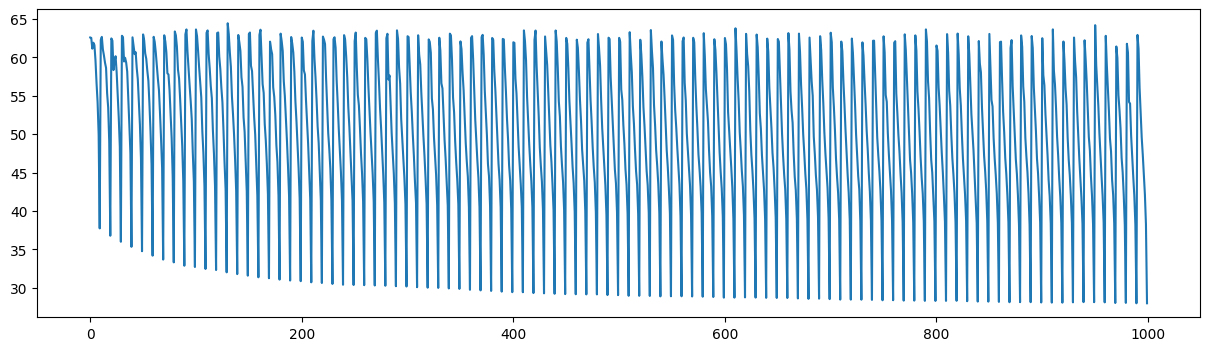

In [11]:
plt.figure(1, figsize=(15, 4))
plt.plot(c)

In [13]:
d = [60.15886688232422,
 58.492584228515625,
 50.50469207763672,
 47.53742980957031,
 45.406982421875,
 41.54552459716797,
 40.92583084106445,
 38.23101806640625,
 35.8779182434082,
 28.881244659423828,
 65.1892318725586,
 53.22270965576172,
 50.154876708984375,
 47.827789306640625,
 43.124977111816406,
 43.72235870361328,
 40.50490188598633,
 38.731998443603516,
 36.17137145996094,
 28.886381149291992,
 65.12484741210938,
 53.02061080932617,
 49.98229217529297,
 46.67041778564453,
 44.424591064453125,
 41.79662322998047,
 39.3473014831543,
 37.88071823120117,
 35.095420837402344,
 28.555252075195312,
 55.55080032348633,
 55.550315856933594,
 51.069881439208984,
 46.97142028808594,
 44.28337097167969,
 41.90052795410156,
 40.350067138671875,
 37.047950744628906,
 35.26276779174805,
 28.230443954467773,
 60.05839157104492,
 49.59904861450195,
 52.100433349609375,
 44.77526092529297,
 42.899078369140625,
 41.16434860229492,
 39.823028564453125,
 37.15949630737305,
 34.737606048583984,
 27.88091278076172,
 68.80975341796875,
 53.096099853515625,
 50.16691207885742,
 47.17099380493164,
 43.02737808227539,
 41.0477294921875,
 39.5770378112793,
 37.18931198120117,
 35.2513427734375,
 27.38710594177246,
 59.00736999511719,
 50.86830520629883,
 48.463844299316406,
 46.717124938964844,
 43.68402099609375,
 40.31962966918945,
 38.965614318847656,
 37.76123046875,
 33.444313049316406,
 26.901409149169922,
 61.61552810668945,
 53.42127990722656,
 48.089210510253906,
 48.45484924316406,
 43.21552276611328,
 40.93655776977539,
 37.93606185913086,
 36.539833068847656,
 33.76418685913086,
 26.428861618041992,
 59.8773193359375,
 52.829402923583984,
 48.725860595703125,
 45.746559143066406,
 42.62428665161133,
 39.87528991699219,
 38.00294494628906,
 35.35737609863281,
 33.03050231933594,
 26.019855499267578,
 60.210533142089844,
 55.27528381347656,
 49.49322509765625,
 45.72352600097656,
 42.56646728515625,
 39.572593688964844,
 37.790260314941406,
 35.33479690551758,
 32.62916946411133,
 25.776918411254883,
 59.57826232910156,
 50.11469268798828,
 50.319332122802734,
 46.53954315185547,
 42.09321594238281,
 38.644447326660156,
 37.30712890625,
 35.72768783569336,
 32.57946014404297,
 25.41134262084961,
 63.23607635498047,
 50.48453903198242,
 48.824974060058594,
 45.120323181152344,
 41.84865188598633,
 39.79286193847656,
 38.130455017089844,
 34.834075927734375,
 31.80792999267578,
 25.174245834350586,
 67.73414611816406,
 53.20587158203125,
 48.77962112426758,
 44.90324401855469,
 41.10863494873047,
 40.37464904785156,
 37.36412811279297,
 34.03110885620117,
 31.529163360595703,
 25.079364776611328,
 59.51121520996094,
 50.695960998535156,
 49.67327880859375,
 46.54146957397461,
 40.927101135253906,
 38.293846130371094,
 36.84714126586914,
 34.332969665527344,
 31.872474670410156,
 24.938432693481445,
 59.923072814941406,
 51.97080993652344,
 49.038780212402344,
 43.46585464477539,
 43.23602294921875,
 38.38549041748047,
 36.67228698730469,
 33.792869567871094,
 31.947694778442383,
 24.731449127197266,
 62.47880935668945,
 53.15419387817383,
 49.79237365722656,
 44.695106506347656,
 41.351463317871094,
 38.95228958129883,
 36.60228729248047,
 33.02027130126953,
 30.482250213623047,
 24.688255310058594,
 63.771270751953125,
 54.5203857421875,
 45.88336181640625,
 45.150123596191406,
 41.077491760253906,
 38.014442443847656,
 35.71678924560547,
 32.781822204589844,
 30.613481521606445,
 24.453041076660156,
 63.226219177246094,
 48.91853332519531,
 46.80781555175781,
 45.180381774902344,
 40.775272369384766,
 37.8376579284668,
 35.404579162597656,
 33.612701416015625,
 30.07063865661621,
 24.332866668701172,
 61.80779266357422,
 56.22711944580078,
 48.79716491699219,
 44.032169342041016,
 40.860591888427734,
 37.16778564453125,
 34.81542205810547,
 32.932979583740234,
 29.625158309936523,
 24.08643341064453,
 63.73321533203125,
 53.98774719238281,
 47.10777282714844,
 44.43292236328125,
 40.694576263427734,
 37.149681091308594,
 34.92848205566406,
 32.840431213378906,
 30.160877227783203,
 24.09736442565918,
 56.95858383178711,
 52.31737518310547,
 46.22051239013672,
 44.85932159423828,
 40.15720748901367,
 36.25860595703125,
 35.19647216796875,
 32.862388610839844,
 30.284543991088867,
 24.035505294799805,
 53.54852294921875,
 49.404029846191406,
 50.606109619140625,
 42.57582473754883,
 38.87871551513672,
 37.7822265625,
 34.20719909667969,
 31.534385681152344,
 29.636051177978516,
 23.882055282592773,
 67.52809143066406,
 50.25446701049805,
 48.19086456298828,
 44.458091735839844,
 40.73973846435547,
 37.11719512939453,
 34.52972412109375,
 30.982685089111328,
 29.043283462524414,
 23.816814422607422,
 61.686737060546875,
 48.945404052734375,
 45.5620231628418,
 44.333900451660156,
 39.112266540527344,
 36.34502029418945,
 32.489036560058594,
 31.977035522460938,
 29.53782081604004,
 23.777198791503906,
 60.2429084777832,
 49.685523986816406,
 48.77496337890625,
 42.57835388183594,
 38.81620407104492,
 35.78112030029297,
 33.29376220703125,
 30.689285278320312,
 29.15494155883789,
 23.692127227783203,
 57.784271240234375,
 50.76224136352539,
 45.72029113769531,
 41.48670959472656,
 38.11300277709961,
 35.13800048828125,
 33.45478820800781,
 32.46013641357422,
 29.19556999206543,
 23.68117904663086,
 63.32228088378906,
 49.284950256347656,
 47.03387451171875,
 43.43349075317383,
 38.23390197753906,
 35.14073944091797,
 33.26255416870117,
 31.535537719726562,
 28.906604766845703,
 23.48733901977539,
 54.76509475708008,
 51.75734329223633,
 47.41994857788086,
 42.84528732299805,
 38.90974807739258,
 35.42698669433594,
 32.81542205810547,
 31.39317512512207,
 28.636451721191406,
 23.45612335205078,
 62.779693603515625,
 52.335777282714844,
 47.64177703857422,
 41.861846923828125,
 39.26921844482422,
 35.28783416748047,
 32.4801025390625,
 31.345233917236328,
 28.85462188720703,
 23.388168334960938,
 60.7502555847168,
 51.686668395996094,
 47.880550384521484,
 42.09819793701172,
 38.39550018310547,
 35.47683334350586,
 33.18077850341797,
 30.893646240234375,
 28.794429779052734,
 23.52165985107422,
 57.8383903503418,
 50.951541900634766,
 47.3212890625,
 42.254600524902344,
 37.57327651977539,
 35.89088439941406,
 32.81988525390625,
 31.188701629638672,
 29.059432983398438,
 23.379486083984375,
 60.690162658691406,
 48.911956787109375,
 46.62952423095703,
 41.55336380004883,
 37.589881896972656,
 34.60600662231445,
 32.70954895019531,
 30.54375648498535,
 28.79511070251465,
 23.3245849609375,
 59.52368927001953,
 51.665531158447266,
 47.86455154418945,
 41.40800094604492,
 36.94172668457031,
 35.09103775024414,
 32.641090393066406,
 30.82365608215332,
 27.99996566772461,
 23.23059844970703,
 59.66741180419922,
 49.542091369628906,
 45.628883361816406,
 42.46125030517578,
 37.31341552734375,
 33.84779739379883,
 32.3951416015625,
 30.701780319213867,
 28.023040771484375,
 23.303428649902344,
 60.23344802856445,
 52.133705139160156,
 49.80011749267578,
 41.376609802246094,
 37.29094696044922,
 35.18278884887695,
 32.61235427856445,
 30.15868377685547,
 28.242021560668945,
 23.250717163085938,
 53.10572814941406,
 52.29798889160156,
 44.787052154541016,
 42.39550018310547,
 39.17835998535156,
 34.21255874633789,
 32.45995330810547,
 30.372642517089844,
 27.93096160888672,
 23.227428436279297,
 57.65499496459961,
 50.979217529296875,
 46.770511627197266,
 40.95618438720703,
 37.82465362548828,
 35.1338005065918,
 31.96784210205078,
 30.907146453857422,
 28.695415496826172,
 23.08978271484375,
 57.52019500732422,
 50.602691650390625,
 45.9067268371582,
 41.33310317993164,
 37.58882141113281,
 35.854087829589844,
 32.97246551513672,
 30.012514114379883,
 27.77948570251465,
 23.120594024658203,
 57.70287322998047,
 54.447906494140625,
 48.21598434448242,
 38.944026947021484,
 36.43804931640625,
 34.15092468261719,
 32.13920593261719,
 30.220502853393555,
 28.24398422241211,
 23.032405853271484,
 57.868247985839844,
 49.96080780029297,
 45.35169982910156,
 40.73499298095703,
 37.304500579833984,
 34.38060760498047,
 32.01359939575195,
 30.315486907958984,
 27.78632926940918,
 22.992637634277344,
 62.963783264160156,
 48.80161666870117,
 45.025611877441406,
 40.685035705566406,
 35.687896728515625,
 33.51866912841797,
 32.30644989013672,
 29.863513946533203,
 27.642629623413086,
 22.966646194458008,
 56.806182861328125,
 52.19496154785156,
 45.44386672973633,
 40.54451370239258,
 36.23291778564453,
 33.778785705566406,
 32.473140716552734,
 29.687694549560547,
 28.229320526123047,
 22.95466423034668,
 57.73236846923828,
 50.859039306640625,
 45.37419509887695,
 40.33974075317383,
 37.93354797363281,
 34.417991638183594,
 32.612125396728516,
 30.56083869934082,
 27.81894302368164,
 22.953563690185547,
 55.41960144042969,
 49.86537170410156,
 45.474002838134766,
 41.00004196166992,
 35.84260559082031,
 34.77812194824219,
 31.711612701416016,
 30.333045959472656,
 27.1807918548584,
 22.829113006591797,
 57.77143096923828,
 53.250038146972656,
 44.23822784423828,
 40.83624267578125,
 36.356536865234375,
 32.09989547729492,
 31.746707916259766,
 29.593063354492188,
 27.336946487426758,
 22.847702026367188,
 61.70964050292969,
 47.40434265136719,
 44.44763946533203,
 41.257164001464844,
 36.29029083251953,
 33.14391326904297,
 32.27613830566406,
 29.974658966064453,
 28.331466674804688,
 22.850399017333984,
 58.221900939941406,
 51.578147888183594,
 47.12302017211914,
 40.19118118286133,
 35.87842559814453,
 33.94977569580078,
 31.531570434570312,
 29.601551055908203,
 26.893089294433594,
 22.798789978027344,
 58.45009994506836,
 48.045372009277344,
 46.77729034423828,
 38.849063873291016,
 36.0155029296875,
 32.66874694824219,
 31.689807891845703,
 30.04991912841797,
 27.376766204833984,
 22.88632583618164,
 51.094810485839844,
 52.66368865966797,
 45.99790954589844,
 38.88987731933594,
 35.77269744873047,
 34.46879196166992,
 32.4298095703125,
 29.27091407775879,
 27.592914581298828,
 22.8504638671875,
 54.91529083251953,
 48.81882095336914,
 43.48643112182617,
 39.517822265625,
 35.92463684082031,
 33.33904266357422,
 31.19687271118164,
 29.758180618286133,
 27.586315155029297,
 22.864364624023438,
 59.22209167480469,
 49.605628967285156,
 43.029483795166016,
 41.64931106567383,
 36.107154846191406,
 33.84014129638672,
 31.23330307006836,
 29.087675094604492,
 26.96718978881836,
 22.792274475097656,
 62.71118927001953,
 50.84300994873047,
 46.5047607421875,
 40.86731719970703,
 35.664100646972656,
 34.522789001464844,
 30.9246826171875,
 29.121376037597656,
 27.414993286132812,
 22.759723663330078,
 54.94505310058594,
 50.96162414550781,
 46.49428176879883,
 38.71690368652344,
 36.37682342529297,
 33.25545883178711,
 31.847930908203125,
 29.229055404663086,
 27.47561264038086,
 22.913799285888672,
 53.2056770324707,
 51.737030029296875,
 43.91168212890625,
 38.48094177246094,
 35.69263458251953,
 33.33135223388672,
 31.268478393554688,
 29.29011344909668,
 27.27549171447754,
 22.794349670410156,
 51.87267303466797,
 50.96580123901367,
 44.39262390136719,
 40.50841522216797,
 36.996253967285156,
 33.14727020263672,
 32.26050567626953,
 28.98638153076172,
 26.72113800048828,
 22.84178352355957,
 62.74888610839844,
 48.91639709472656,
 44.669464111328125,
 39.12306213378906,
 37.15697479248047,
 33.39287567138672,
 31.38351058959961,
 29.417373657226562,
 26.963531494140625,
 22.76366424560547,
 65.27802276611328,
 53.25291442871094,
 43.88201141357422,
 39.174747467041016,
 35.54532241821289,
 33.739952087402344,
 30.784820556640625,
 29.385786056518555,
 26.792713165283203,
 22.849407196044922,
 56.33330535888672,
 49.993526458740234,
 44.4007453918457,
 37.977806091308594,
 35.45479202270508,
 32.674381256103516,
 31.958675384521484,
 29.17938232421875,
 27.346328735351562,
 22.833282470703125,
 62.30924987792969,
 49.953704833984375,
 44.19662094116211,
 39.447853088378906,
 36.617637634277344,
 32.86536407470703,
 30.708248138427734,
 29.241352081298828,
 26.96415138244629,
 22.766611099243164,
 55.66059875488281,
 50.7301025390625,
 45.360496520996094,
 39.665061950683594,
 35.4742431640625,
 33.17741012573242,
 32.021202087402344,
 29.39190673828125,
 26.988609313964844,
 22.80621337890625,
 62.54186248779297,
 52.615081787109375,
 45.603919982910156,
 37.36106872558594,
 35.86526870727539,
 33.64152526855469,
 30.69938087463379,
 28.91562271118164,
 26.451366424560547,
 22.859569549560547,
 53.02123260498047,
 50.34745788574219,
 43.745704650878906,
 38.428428649902344,
 35.51535415649414,
 33.600379943847656,
 31.50011444091797,
 29.125019073486328,
 26.837234497070312,
 22.84341812133789,
 64.2995834350586,
 51.97460174560547,
 46.212013244628906,
 38.743186950683594,
 35.197776794433594,
 32.95549011230469,
 31.03363800048828,
 29.054492950439453,
 26.447145462036133,
 22.697322845458984,
 60.59577941894531,
 54.298458099365234,
 43.2993049621582,
 38.862815856933594,
 35.62479019165039,
 33.09869384765625,
 30.547868728637695,
 29.082378387451172,
 26.814590454101562,
 22.73552894592285,
 54.21369171142578,
 52.76851272583008,
 44.124847412109375,
 37.90453338623047,
 35.81671905517578,
 33.52497100830078,
 31.652149200439453,
 28.90597152709961,
 26.217025756835938,
 22.809097290039062,
 59.4796142578125,
 49.93022155761719,
 44.89299011230469,
 38.48101806640625,
 35.70583724975586,
 33.164817810058594,
 30.894041061401367,
 28.899370193481445,
 26.693584442138672,
 22.672082901000977,
 56.391021728515625,
 49.64631652832031,
 41.68291473388672,
 37.85361099243164,
 36.519683837890625,
 33.44593811035156,
 31.06096076965332,
 28.439403533935547,
 26.10804557800293,
 22.663469314575195,
 59.95840072631836,
 51.29730987548828,
 43.115970611572266,
 38.31292724609375,
 35.54541015625,
 32.96851348876953,
 30.777381896972656,
 28.622203826904297,
 26.59791374206543,
 22.668710708618164,
 55.68163299560547,
 50.52463912963867,
 44.03286361694336,
 37.64919662475586,
 35.89434051513672,
 33.262245178222656,
 30.665969848632812,
 28.62893295288086,
 26.08163833618164,
 22.628835678100586,
 60.281349182128906,
 49.953365325927734,
 45.14252471923828,
 39.531158447265625,
 34.987998962402344,
 32.497779846191406,
 31.180156707763672,
 28.750244140625,
 26.207969665527344,
 22.652793884277344,
 54.9373779296875,
 51.324798583984375,
 41.05758285522461,
 38.66307830810547,
 35.671775817871094,
 32.460182189941406,
 30.67559051513672,
 29.168655395507812,
 26.2701358795166,
 22.729846954345703,
 59.60976791381836,
 51.413570404052734,
 43.33671569824219,
 39.718345642089844,
 35.514137268066406,
 33.95524978637695,
 31.11404800415039,
 28.36702537536621,
 25.956966400146484,
 22.62109375,
 65.50886535644531,
 49.90771484375,
 45.693450927734375,
 38.095157623291016,
 36.073699951171875,
 32.425838470458984,
 31.020923614501953,
 29.065410614013672,
 26.186969757080078,
 22.649858474731445,
 57.68454360961914,
 48.73448181152344,
 44.22809600830078,
 39.21405792236328,
 34.82275390625,
 33.25606155395508,
 32.0464973449707,
 28.89853286743164,
 26.324615478515625,
 22.58960723876953,
 53.1060905456543,
 51.858924865722656,
 42.508277893066406,
 38.69609069824219,
 35.169471740722656,
 33.6732177734375,
 30.830842971801758,
 28.883197784423828,
 26.064373016357422,
 22.640766143798828,
 60.07453918457031,
 49.114654541015625,
 41.8487434387207,
 38.77793884277344,
 35.178260803222656,
 32.715667724609375,
 30.074283599853516,
 29.276947021484375,
 26.500450134277344,
 22.59011459350586,
 60.580177307128906,
 50.38747787475586,
 41.38257598876953,
 37.67805480957031,
 36.37073516845703,
 33.562381744384766,
 31.647472381591797,
 28.609413146972656,
 26.4625186920166,
 22.607810974121094,
 54.01596450805664,
 52.94355010986328,
 42.253814697265625,
 38.162750244140625,
 35.001922607421875,
 32.65589904785156,
 30.446575164794922,
 28.66581916809082,
 25.84288787841797,
 22.54903793334961,
 58.1349983215332,
 52.120933532714844,
 42.52116775512695,
 38.278602600097656,
 34.73435592651367,
 32.728912353515625,
 30.922100067138672,
 28.953927993774414,
 26.37047576904297,
 22.810768127441406,
 64.25271606445312,
 56.09886169433594,
 42.91574478149414,
 38.25002670288086,
 34.384742736816406,
 32.11083221435547,
 30.863510131835938,
 28.83699607849121,
 26.016624450683594,
 22.651107788085938,
 61.144004821777344,
 52.76164245605469,
 42.75656509399414,
 38.553531646728516,
 35.1922607421875,
 32.706031799316406,
 30.537137985229492,
 28.398021697998047,
 25.699386596679688,
 22.753841400146484,
 61.099735260009766,
 48.71221923828125,
 43.11716842651367,
 38.91886901855469,
 35.26035690307617,
 32.691802978515625,
 30.731626510620117,
 28.62085723876953,
 25.78128433227539,
 22.610111236572266,
 60.326725006103516,
 51.71277618408203,
 42.15892791748047,
 38.54109191894531,
 35.26329040527344,
 32.77301025390625,
 30.666881561279297,
 28.17643928527832,
 25.667932510375977,
 22.885711669921875,
 54.169883728027344,
 51.79832458496094,
 45.16340637207031,
 40.30656433105469,
 35.31745529174805,
 32.965633392333984,
 30.608556747436523,
 28.26171875,
 25.922588348388672,
 22.701801300048828,
 62.50596618652344,
 49.15467834472656,
 43.56663513183594,
 37.60028076171875,
 35.60436248779297,
 32.39117431640625,
 30.81661605834961,
 28.12137222290039,
 25.8375186920166,
 22.719812393188477,
 59.238494873046875,
 48.53707504272461,
 42.702308654785156,
 37.221553802490234,
 36.4693489074707,
 32.54169464111328,
 30.366683959960938,
 27.570110321044922,
 25.324020385742188,
 22.800697326660156,
 55.579349517822266,
 50.52537536621094,
 43.63084411621094,
 37.12910842895508,
 35.792564392089844,
 32.4542236328125,
 30.996055603027344,
 28.595487594604492,
 25.78742218017578,
 22.83090591430664,
 56.436920166015625,
 48.45482635498047,
 43.02470779418945,
 38.21201705932617,
 34.19351577758789,
 33.863929748535156,
 30.902957916259766,
 28.722366333007812,
 25.91612434387207,
 22.744457244873047,
 55.61093521118164,
 48.15073013305664,
 42.124176025390625,
 38.51417541503906,
 36.666900634765625,
 32.70842742919922,
 30.47093391418457,
 28.471084594726562,
 25.912200927734375,
 22.880992889404297,
 59.43806838989258,
 51.696319580078125,
 43.45354080200195,
 37.053985595703125,
 34.94451904296875,
 31.941476821899414,
 31.129335403442383,
 28.3741455078125,
 25.975204467773438,
 22.925640106201172,
 59.90153503417969,
 47.88258361816406,
 43.32600784301758,
 37.829376220703125,
 34.13592529296875,
 32.177589416503906,
 29.83032989501953,
 27.86117172241211,
 25.12376594543457,
 22.681821823120117,
 57.501609802246094,
 44.70660400390625,
 41.86634063720703,
 39.36339569091797,
 34.461578369140625,
 32.55066680908203,
 30.83346176147461,
 27.947612762451172,
 25.579185485839844,
 22.841360092163086,
 57.23131561279297,
 50.424285888671875,
 42.357276916503906,
 36.976985931396484,
 34.97408676147461,
 32.84906005859375,
 30.553075790405273,
 28.57685089111328,
 25.443628311157227,
 22.906719207763672,
 61.030548095703125,
 52.412940979003906,
 43.05531311035156,
 38.52166748046875,
 34.65312957763672,
 32.893577575683594,
 30.203306198120117,
 28.897743225097656,
 25.59002685546875,
 22.852596282958984,
 52.34927749633789,
 51.68932342529297,
 44.45721435546875,
 36.84125518798828,
 34.99485778808594,
 32.876190185546875,
 30.708351135253906,
 27.728288650512695,
 25.423065185546875,
 22.981271743774414,
 61.90519714355469,
 51.0645751953125,
 42.381954193115234,
 37.96897506713867,
 34.82039260864258,
 33.72727584838867,
 30.65399932861328,
 28.745853424072266,
 25.41352081298828,
 22.888404846191406,
 57.18206787109375,
 50.93720245361328,
 43.796875,
 39.3343505859375,
 34.544212341308594,
 33.09223175048828,
 30.560853958129883,
 28.496009826660156,
 25.77741241455078,
 23.160804748535156,
 66.84898376464844,
 50.7542724609375,
 42.91438674926758,
 38.226226806640625,
 35.209503173828125,
 32.684757232666016,
 30.386157989501953,
 28.722423553466797,
 25.64927101135254,
 22.764827728271484,
 57.86908721923828,
 51.386260986328125,
 42.86622619628906,
 39.61891174316406,
 34.87788009643555,
 31.948894500732422,
 30.521459579467773,
 28.309917449951172,
 25.49016761779785,
 22.907878875732422,
 57.225791931152344,
 50.807029724121094,
 41.67518615722656,
 37.863433837890625,
 34.36267852783203,
 32.21736526489258,
 30.539520263671875,
 28.972610473632812,
 25.910736083984375,
 22.7987060546875]

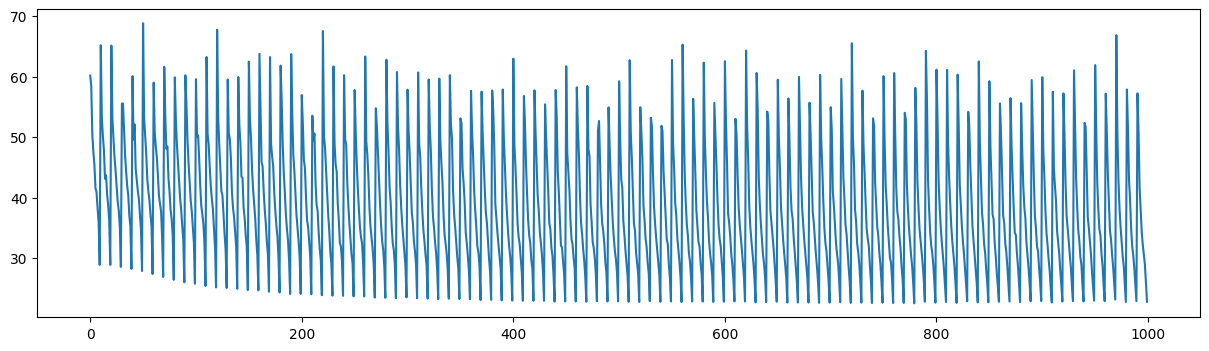

In [14]:
plt.figure(1, figsize=(15, 4))
plt.plot(d)

In [15]:
e = [60.15886688232422,
 58.492584228515625,
 50.50469207763672,
 47.53742980957031,
 45.406982421875,
 41.54552459716797,
 40.92583084106445,
 38.23101806640625,
 35.8779182434082,
 28.881244659423828,
 65.21038818359375,
 53.21064376831055,
 50.205421447753906,
 47.8558349609375,
 43.15298843383789,
 43.777530670166016,
 40.503108978271484,
 38.82052993774414,
 36.34128189086914,
 29.0386962890625,
 65.24527740478516,
 53.16212463378906,
 50.207763671875,
 46.799156188964844,
 44.678993225097656,
 42.013450622558594,
 39.5860710144043,
 38.1207275390625,
 35.54955291748047,
 28.931507110595703,
 55.54161834716797,
 55.77513885498047,
 51.39165496826172,
 47.18475341796875,
 44.60704803466797,
 42.17573547363281,
 40.687652587890625,
 37.88992691040039,
 36.03419494628906,
 28.893131256103516,
 60.37921905517578,
 49.86797332763672,
 52.555816650390625,
 45.006256103515625,
 43.17973709106445,
 41.842891693115234,
 40.41499328613281,
 38.08056640625,
 35.632911682128906,
 28.826648712158203,
 69.34566497802734,
 53.597557067871094,
 50.76040267944336,
 47.64979553222656,
 43.59838104248047,
 41.77158737182617,
 40.441551208496094,
 38.5008430480957,
 36.57731628417969,
 28.711261749267578,
 59.194889068603516,
 50.659786224365234,
 48.85148620605469,
 47.2557373046875,
 45.13603210449219,
 41.2066650390625,
 40.14048385620117,
 39.02326965332031,
 34.999114990234375,
 28.645061492919922,
 61.55189514160156,
 54.013755798339844,
 49.05799865722656,
 49.02349853515625,
 44.032920837402344,
 41.8474235534668,
 39.45269775390625,
 38.567203521728516,
 35.77256774902344,
 28.48346710205078,
 60.675697326660156,
 54.04365539550781,
 49.966026306152344,
 46.732093811035156,
 43.639122009277344,
 40.899658203125,
 39.6999397277832,
 37.41639709472656,
 35.23303985595703,
 28.378385543823242,
 61.05894470214844,
 56.26508712768555,
 50.79417419433594,
 46.537071228027344,
 43.7073974609375,
 40.94776916503906,
 39.654911041259766,
 37.79953384399414,
 35.267032623291016,
 28.380189895629883,
 60.119964599609375,
 50.62688446044922,
 51.7069206237793,
 48.34566116333008,
 43.31524658203125,
 40.63093948364258,
 39.4628791809082,
 38.097373962402344,
 35.19889831542969,
 28.222309112548828,
 63.98042297363281,
 51.71766662597656,
 50.16398620605469,
 46.86076354980469,
 43.71034240722656,
 41.497169494628906,
 40.3682861328125,
 37.92295837402344,
 34.64533233642578,
 28.111726760864258,
 68.36100006103516,
 54.57488250732422,
 50.38810348510742,
 47.09001922607422,
 42.465328216552734,
 42.07257080078125,
 40.4969482421875,
 37.459503173828125,
 34.32216262817383,
 28.073974609375,
 60.00775146484375,
 52.08919143676758,
 51.079776763916016,
 47.936546325683594,
 43.102569580078125,
 40.411293029785156,
 39.7827262878418,
 37.16082763671875,
 35.1885871887207,
 28.005760192871094,
 60.401458740234375,
 53.67488098144531,
 50.043373107910156,
 45.77783203125,
 44.92377471923828,
 40.81945037841797,
 39.80384826660156,
 36.84269714355469,
 35.75817108154297,
 27.718652725219727,
 62.83621597290039,
 55.32169723510742,
 51.54143524169922,
 46.645572662353516,
 44.08506774902344,
 41.77922439575195,
 39.90856170654297,
 37.434898376464844,
 34.300498962402344,
 27.668638229370117,
 64.81993103027344,
 56.554744720458984,
 46.79102325439453,
 46.222999572753906,
 42.72602462768555,
 40.947959899902344,
 39.324684143066406,
 35.99525451660156,
 34.22166061401367,
 27.46947479248047,
 64.54664611816406,
 49.499366760253906,
 48.249267578125,
 46.74757385253906,
 43.26800537109375,
 41.187259674072266,
 39.054527282714844,
 37.326507568359375,
 33.61302185058594,
 27.28850555419922,
 62.87419891357422,
 57.418243408203125,
 51.18252182006836,
 46.832542419433594,
 44.85221862792969,
 40.576934814453125,
 38.6007080078125,
 37.07207489013672,
 33.44178009033203,
 27.12934684753418,
 63.033226013183594,
 58.17320251464844,
 48.87606430053711,
 46.13420104980469,
 43.772056579589844,
 40.91132354736328,
 39.75593948364258,
 36.429115295410156,
 34.02348327636719,
 27.00592613220215,
 59.01898193359375,
 54.79547882080078,
 47.06854248046875,
 46.75648498535156,
 43.599117279052734,
 39.766761779785156,
 38.7952880859375,
 36.950904846191406,
 34.45904541015625,
 27.044740676879883,
 52.71235656738281,
 50.79607391357422,
 51.80927276611328,
 44.167999267578125,
 42.41029739379883,
 41.086769104003906,
 38.110923767089844,
 36.252037048339844,
 33.97766876220703,
 26.74106216430664,
 67.76078033447266,
 51.577728271484375,
 49.79616165161133,
 46.798118591308594,
 44.343013763427734,
 41.03959655761719,
 39.150794982910156,
 35.51838684082031,
 33.277671813964844,
 26.567148208618164,
 62.748374938964844,
 52.55653381347656,
 47.62653732299805,
 48.462242126464844,
 42.32357406616211,
 41.258018493652344,
 38.02248001098633,
 36.530242919921875,
 33.56798553466797,
 26.409385681152344,
 62.49858474731445,
 52.720821380615234,
 51.67851257324219,
 46.31289291381836,
 42.48973083496094,
 39.73072052001953,
 37.59799575805664,
 34.9631462097168,
 33.36608123779297,
 26.368513107299805,
 58.438629150390625,
 52.45851516723633,
 48.20113754272461,
 44.1822509765625,
 41.30640411376953,
 39.001319885253906,
 38.40980529785156,
 37.164405822753906,
 33.293006896972656,
 26.273616790771484,
 63.297760009765625,
 50.837364196777344,
 49.08543395996094,
 46.543190002441406,
 43.04722213745117,
 40.77510070800781,
 37.45081329345703,
 35.4550666809082,
 32.78254699707031,
 25.994688034057617,
 55.97236633300781,
 54.926361083984375,
 49.08692169189453,
 44.74683380126953,
 42.870216369628906,
 38.80284118652344,
 37.43522644042969,
 35.791893005371094,
 33.074684143066406,
 25.988140106201172,
 66.05094909667969,
 53.76945495605469,
 49.203636169433594,
 44.953243255615234,
 44.169212341308594,
 40.671905517578125,
 37.407623291015625,
 35.69397735595703,
 33.32737731933594,
 25.839508056640625,
 57.99848937988281,
 52.83905029296875,
 49.6510009765625,
 44.370201110839844,
 42.128578186035156,
 40.66565704345703,
 37.27720642089844,
 35.28929138183594,
 33.065425872802734,
 25.959033966064453,
 57.615882873535156,
 52.962890625,
 49.467247009277344,
 45.311885833740234,
 41.57042694091797,
 39.796424865722656,
 37.212215423583984,
 35.05820846557617,
 33.100730895996094,
 25.693397521972656,
 60.050636291503906,
 51.02495574951172,
 49.29502487182617,
 45.767364501953125,
 42.067726135253906,
 40.43954086303711,
 37.73007583618164,
 35.24232482910156,
 32.68061828613281,
 25.597434997558594,
 58.667850494384766,
 53.47898864746094,
 51.05849075317383,
 45.122802734375,
 41.92188262939453,
 39.744632720947266,
 37.25473403930664,
 35.057220458984375,
 31.87561798095703,
 25.492618560791016,
 62.35453796386719,
 51.47575378417969,
 47.816322326660156,
 44.94842529296875,
 42.24321746826172,
 40.087158203125,
 36.750755310058594,
 35.04339599609375,
 31.529178619384766,
 25.55402374267578,
 61.273773193359375,
 54.99263381958008,
 52.7332763671875,
 44.70354080200195,
 42.47034454345703,
 39.34507751464844,
 37.00560760498047,
 34.43075942993164,
 32.131080627441406,
 25.424755096435547,
 54.20500946044922,
 54.12334442138672,
 48.22488784790039,
 46.69451141357422,
 42.762351989746094,
 39.06587219238281,
 36.795326232910156,
 35.025856018066406,
 31.664859771728516,
 25.366239547729492,
 59.35829162597656,
 53.010257720947266,
 48.79998779296875,
 45.62007141113281,
 42.74595642089844,
 40.17940139770508,
 36.64862823486328,
 35.375205993652344,
 32.47776794433594,
 25.2336368560791,
 59.17826843261719,
 52.52567672729492,
 48.10449981689453,
 46.632171630859375,
 42.34841537475586,
 39.97686004638672,
 37.00434112548828,
 34.61760711669922,
 31.710941314697266,
 25.254901885986328,
 57.08808135986328,
 56.3493537902832,
 52.11836242675781,
 43.73988342285156,
 41.477264404296875,
 38.55401611328125,
 37.28066635131836,
 34.65351867675781,
 32.20372772216797,
 25.156757354736328,
 62.03119659423828,
 51.649879455566406,
 49.01371765136719,
 44.71173095703125,
 42.11811828613281,
 38.80312728881836,
 37.26213073730469,
 34.413578033447266,
 32.169795989990234,
 25.06363296508789,
 64.74127960205078,
 48.75822067260742,
 47.51060104370117,
 44.5668830871582,
 40.54932403564453,
 38.50656509399414,
 37.145957946777344,
 33.92814636230469,
 31.54933738708496,
 24.965076446533203,
 59.21106719970703,
 53.79472732543945,
 48.43928146362305,
 45.503849029541016,
 40.80006408691406,
 38.23673629760742,
 36.947364807128906,
 34.03544616699219,
 31.82543182373047,
 25.002483367919922,
 60.305843353271484,
 52.366180419921875,
 47.429141998291016,
 44.0245475769043,
 41.88027572631836,
 38.495521545410156,
 37.16273498535156,
 34.98866271972656,
 31.569812774658203,
 24.890960693359375,
 57.979736328125,
 51.426605224609375,
 48.678035736083984,
 45.559356689453125,
 41.30927276611328,
 39.59425354003906,
 36.223976135253906,
 34.19740295410156,
 31.159278869628906,
 24.80080795288086,
 61.49022674560547,
 55.63700866699219,
 47.45083999633789,
 45.21341323852539,
 40.478790283203125,
 39.028282165527344,
 35.12848663330078,
 33.080055236816406,
 30.846786499023438,
 24.79256820678711,
 60.375701904296875,
 47.82276153564453,
 47.40043258666992,
 45.12201690673828,
 41.13329315185547,
 38.509925842285156,
 35.84111785888672,
 34.392967224121094,
 32.17628860473633,
 24.750883102416992,
 57.92066192626953,
 53.086769104003906,
 49.61199188232422,
 45.34794616699219,
 41.192413330078125,
 39.051517486572266,
 35.871910095214844,
 33.37016296386719,
 30.238712310791016,
 24.577373504638672,
 59.851539611816406,
 49.58837890625,
 48.815792083740234,
 44.50524139404297,
 42.56147384643555,
 38.176292419433594,
 35.500885009765625,
 33.9669189453125,
 31.2912540435791,
 24.589075088500977,
 54.103416442871094,
 54.27742004394531,
 51.37232971191406,
 44.18326950073242,
 41.76776885986328,
 39.67094421386719,
 35.80759811401367,
 33.46086120605469,
 30.948001861572266,
 24.551925659179688,
 55.365455627441406,
 50.4238166809082,
 47.20619201660156,
 44.00278091430664,
 40.04088592529297,
 37.977638244628906,
 36.01958084106445,
 33.50678253173828,
 30.798519134521484,
 24.529964447021484,
 61.17657470703125,
 51.88584518432617,
 46.236907958984375,
 45.81829071044922,
 41.10529327392578,
 38.618568420410156,
 35.31285095214844,
 33.451133728027344,
 30.200927734375,
 24.442115783691406,
 66.02523803710938,
 50.959808349609375,
 48.69065475463867,
 47.46937561035156,
 40.775638580322266,
 38.95172119140625,
 35.494049072265625,
 33.22285461425781,
 30.54265594482422,
 24.38680648803711,
 56.617759704589844,
 50.34470748901367,
 48.783592224121094,
 44.92683410644531,
 40.75267791748047,
 38.54126739501953,
 35.14324188232422,
 33.00404357910156,
 30.98377227783203,
 24.463714599609375,
 55.070289611816406,
 54.68195343017578,
 46.26484680175781,
 45.940399169921875,
 40.10936737060547,
 37.39799880981445,
 34.83743667602539,
 33.29827117919922,
 30.762210845947266,
 24.294933319091797,
 53.73729705810547,
 51.514827728271484,
 49.549896240234375,
 45.298892974853516,
 40.15709686279297,
 37.824501037597656,
 35.939537048339844,
 32.89936447143555,
 29.985931396484375,
 24.28607749938965,
 61.28171920776367,
 49.689857482910156,
 47.94337463378906,
 44.25688552856445,
 41.92841339111328,
 38.826438903808594,
 35.403804779052734,
 33.094024658203125,
 30.26030731201172,
 24.191577911376953,
 67.55538940429688,
 56.20786666870117,
 47.209049224853516,
 43.34796905517578,
 41.83692932128906,
 38.745567321777344,
 35.210514068603516,
 32.90086364746094,
 30.12712860107422,
 24.16980743408203,
 58.26310729980469,
 51.624088287353516,
 47.91200256347656,
 44.11475372314453,
 40.66035079956055,
 37.58734893798828,
 35.752498626708984,
 32.899261474609375,
 30.41689682006836,
 24.149768829345703,
 64.49421691894531,
 51.161476135253906,
 46.441436767578125,
 43.537601470947266,
 40.73857116699219,
 38.13064956665039,
 33.86332702636719,
 32.710723876953125,
 30.37948989868164,
 24.050792694091797,
 57.552059173583984,
 49.6001091003418,
 46.31874084472656,
 44.426612854003906,
 40.550254821777344,
 37.44687271118164,
 35.88606262207031,
 32.86671447753906,
 30.307048797607422,
 24.09716033935547,
 61.73078918457031,
 52.560333251953125,
 49.35474395751953,
 43.50341033935547,
 38.76057434082031,
 38.04008865356445,
 34.22416687011719,
 32.319461822509766,
 29.73154640197754,
 24.105852127075195,
 53.09110641479492,
 52.64338684082031,
 48.08055114746094,
 44.50025939941406,
 41.492252349853516,
 36.88731384277344,
 35.07220458984375,
 32.42230987548828,
 30.247159957885742,
 24.00787353515625,
 65.75299072265625,
 50.80653381347656,
 48.55863571166992,
 45.123390197753906,
 40.34129333496094,
 36.15502166748047,
 35.27461242675781,
 32.629547119140625,
 29.276960372924805,
 23.923095703125,
 63.911197662353516,
 54.09202194213867,
 47.11365509033203,
 43.6495246887207,
 41.07152557373047,
 36.99779510498047,
 34.91992950439453,
 32.097068786621094,
 30.120853424072266,
 23.900699615478516,
 58.1160774230957,
 55.87053680419922,
 47.78898239135742,
 42.874507904052734,
 40.376502990722656,
 37.09312438964844,
 35.38309097290039,
 32.264808654785156,
 29.458147048950195,
 23.82122802734375,
 60.29652786254883,
 49.8890380859375,
 47.18251037597656,
 44.489158630371094,
 39.8693962097168,
 37.141746520996094,
 33.55959701538086,
 32.23771667480469,
 30.105052947998047,
 23.813167572021484,
 57.37763977050781,
 50.087799072265625,
 47.096309661865234,
 42.77485656738281,
 41.465110778808594,
 36.403541564941406,
 34.133426666259766,
 31.512157440185547,
 29.517993927001953,
 23.84210777282715,
 59.9091796875,
 52.25164031982422,
 46.50501251220703,
 43.321022033691406,
 41.025047302246094,
 35.757198333740234,
 34.237640380859375,
 31.72520637512207,
 29.642562866210938,
 23.83851432800293,
 56.20600891113281,
 52.11408996582031,
 47.008033752441406,
 45.49280548095703,
 39.66750717163086,
 36.8680419921875,
 34.70626449584961,
 31.375591278076172,
 28.82275390625,
 23.75599479675293,
 60.35230255126953,
 51.18865966796875,
 47.31698226928711,
 45.14649200439453,
 40.046295166015625,
 36.107521057128906,
 34.631107330322266,
 31.38327407836914,
 29.232418060302734,
 23.777000427246094,
 55.49797821044922,
 52.39923095703125,
 44.0179443359375,
 44.010562896728516,
 39.24443054199219,
 35.83435821533203,
 34.12738037109375,
 31.745361328125,
 29.098899841308594,
 23.83794593811035,
 59.92062759399414,
 52.476097106933594,
 46.36710739135742,
 44.6259765625,
 39.7080192565918,
 37.43962097167969,
 34.157684326171875,
 30.943336486816406,
 28.990707397460938,
 23.761367797851562,
 62.43504333496094,
 52.327232360839844,
 50.70109558105469,
 43.63066482543945,
 39.9433708190918,
 36.29609680175781,
 34.78966522216797,
 32.073936462402344,
 29.274932861328125,
 23.72649383544922,
 56.611602783203125,
 48.91261672973633,
 48.795135498046875,
 43.17487335205078,
 39.126861572265625,
 36.55308532714844,
 34.518707275390625,
 31.504867553710938,
 29.479690551757812,
 23.70514678955078,
 53.29347610473633,
 53.297672271728516,
 47.02867126464844,
 42.14789581298828,
 39.33024978637695,
 37.11515426635742,
 33.84071350097656,
 31.714344024658203,
 29.10934066772461,
 23.714099884033203,
 64.19754791259766,
 50.20960235595703,
 46.683265686035156,
 44.09041976928711,
 38.900474548339844,
 36.590667724609375,
 33.843509674072266,
 31.904197692871094,
 29.474525451660156,
 23.64797592163086,
 59.69122314453125,
 51.42750930786133,
 46.77625274658203,
 42.345458984375,
 38.99116897583008,
 36.57868194580078,
 34.748817443847656,
 31.225811004638672,
 29.4720458984375,
 23.61534309387207,
 54.152366638183594,
 54.371246337890625,
 46.37841033935547,
 43.352298736572266,
 39.07830047607422,
 36.626548767089844,
 33.287200927734375,
 31.188129425048828,
 28.97226333618164,
 23.56752586364746,
 60.10578536987305,
 55.203651428222656,
 46.53150177001953,
 42.22875213623047,
 38.965816497802734,
 36.41278839111328,
 33.83794021606445,
 31.658842086791992,
 29.615055084228516,
 23.62115478515625,
 66.70833587646484,
 54.5893669128418,
 46.801517486572266,
 43.56124496459961,
 38.31188201904297,
 36.13268280029297,
 34.09857177734375,
 31.904193878173828,
 29.44391632080078,
 23.54285430908203,
 59.90568923950195,
 52.99934005737305,
 46.28465270996094,
 43.04163360595703,
 40.01020050048828,
 35.33251190185547,
 32.68101119995117,
 30.910743713378906,
 28.45635986328125,
 23.61102867126465,
 63.48989486694336,
 50.090728759765625,
 45.808048248291016,
 43.32310104370117,
 38.06853485107422,
 35.55964660644531,
 32.654903411865234,
 31.543397903442383,
 28.50920295715332,
 23.598506927490234,
 59.51099395751953,
 54.239234924316406,
 45.75774383544922,
 41.920684814453125,
 38.090389251708984,
 35.69432067871094,
 33.93891143798828,
 30.920238494873047,
 28.88538360595703,
 23.593032836914062,
 55.41399383544922,
 52.74409484863281,
 48.67750930786133,
 43.27376174926758,
 38.523170471191406,
 35.57960891723633,
 33.23737335205078,
 30.147008895874023,
 28.820966720581055,
 23.532472610473633,
 60.620948791503906,
 51.192588806152344,
 47.325111389160156,
 42.78038787841797,
 39.46485900878906,
 34.58658218383789,
 34.1131706237793,
 30.985187530517578,
 29.087017059326172,
 23.53510284423828,
 58.83076477050781,
 51.51703643798828,
 48.39317321777344,
 41.25130844116211,
 39.499969482421875,
 35.459434509277344,
 32.40644836425781,
 29.937957763671875,
 28.30135726928711,
 23.515674591064453,
 56.58777618408203,
 50.067832946777344,
 47.81671905517578,
 41.241844177246094,
 38.572574615478516,
 35.81317138671875,
 33.305213928222656,
 31.31572723388672,
 29.010465621948242,
 23.423494338989258,
 54.76658630371094,
 47.337608337402344,
 47.36594009399414,
 42.51527786254883,
 38.89081573486328,
 36.611637115478516,
 33.460506439208984,
 30.98982048034668,
 28.860231399536133,
 23.364654541015625,
 55.04259490966797,
 49.15443420410156,
 45.56650924682617,
 41.28049087524414,
 39.80390548706055,
 36.06555938720703,
 33.43352508544922,
 30.683927536010742,
 29.11749267578125,
 23.502243041992188,
 60.72491455078125,
 49.819488525390625,
 45.640750885009766,
 41.311065673828125,
 38.24104309082031,
 36.03022766113281,
 32.746337890625,
 31.085468292236328,
 28.785751342773438,
 23.522296905517578,
 59.433387756347656,
 48.29804992675781,
 47.01166534423828,
 42.587642669677734,
 37.580589294433594,
 34.3128662109375,
 32.194252014160156,
 30.2712459564209,
 27.995929718017578,
 23.38833999633789,
 55.327735900878906,
 51.06414794921875,
 45.90068054199219,
 42.36860656738281,
 38.17557144165039,
 35.80363082885742,
 32.696624755859375,
 30.687877655029297,
 28.458757400512695,
 23.404279708862305,
 57.33355712890625,
 52.715904235839844,
 46.16499328613281,
 40.37696838378906,
 39.23645782470703,
 35.41181182861328,
 32.72068405151367,
 31.396146774291992,
 28.398601531982422,
 23.321365356445312,
 59.925506591796875,
 52.133056640625,
 45.869468688964844,
 42.16963195800781,
 38.99868392944336,
 34.769779205322266,
 32.553733825683594,
 31.273681640625,
 28.39586067199707,
 23.415388107299805,
 52.42634201049805,
 52.94188690185547,
 48.72370910644531,
 40.7750244140625,
 38.245853424072266,
 35.46132278442383,
 32.66150665283203,
 29.911231994628906,
 28.571685791015625,
 23.341148376464844,
 62.15275955200195,
 51.094696044921875,
 44.58910369873047,
 41.56630325317383,
 37.68402862548828,
 35.4989128112793,
 32.77142333984375,
 31.19423484802246,
 28.173171997070312,
 23.356626510620117,
 57.9904670715332,
 52.39930725097656,
 49.010162353515625,
 41.9238166809082,
 37.48045349121094,
 35.72471237182617,
 32.70267105102539,
 30.890914916992188,
 28.308866500854492,
 23.256420135498047,
 64.04251098632812,
 50.05987548828125,
 48.00117111206055,
 41.8583984375,
 38.1264762878418,
 34.84836196899414,
 32.11243438720703,
 31.17612075805664,
 28.638851165771484,
 23.316753387451172,
 57.02751159667969,
 49.15611267089844,
 45.798458099365234,
 44.246726989746094,
 36.82820129394531,
 34.39440155029297,
 32.478248596191406,
 30.234132766723633,
 28.29127311706543,
 23.318557739257812,
 55.75078582763672,
 49.73926544189453,
 46.066341400146484,
 40.59254837036133,
 36.976173400878906,
 34.82038116455078,
 33.26398468017578,
 31.222278594970703,
 28.654678344726562,
 23.204526901245117]

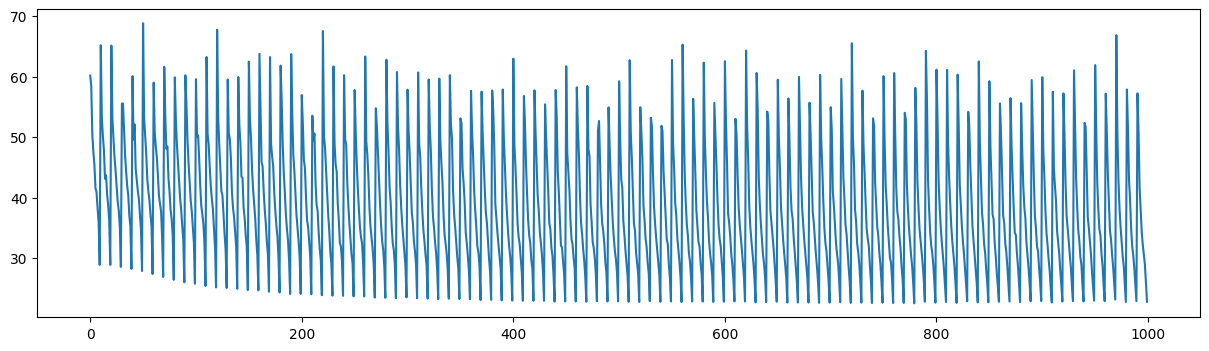

In [16]:
plt.figure(1, figsize=(15, 4))
plt.plot(d)